###  해당 커널은 다음과 같은 프로세스로 진행

1. 데이터 셋 확인
    * 데이터가 어떻게 구성되어 있는지 확인
    * 대부분의 캐글 데이터들은 잘 정제되어 있지만 실제 데이터는 아닐 가능성이 농후
      
    하지만 가끔 null data가 존재합니다. 이를 확인하고, 향후 수정
2. 탐색적 데이터 분석 (EDA, Exploratory Data Analysis)
    * 여러 feature 들을 개별적으로 분석하고, feature 들 간의 상관관계를 확인
      
    여러 시각화 툴을 사용하여 insight를 획득
3. 특성 공학 (Feature Engineering)
    * 모델을 세우기에 앞서, 모델의 성능을 높일 수 있도록 feature 들을 engineering 한다.
      
    one-hot encoding, class로 나누기, 구간으로 나누기, 텍스트 데이터 처리
4. 모델 개발 및 학습
    * sklearn, keras 을 사용해 모델을 만든다.
    * 파이썬에서 머신러닝을 할 때는 sklearn 을 사용하면 수많은 알고리즘을 일관된 문법으로 사용 가능
    * 또 keras는 딥러닝 개발할 때 모델에 집중할 수 있도록 도움.
    * 물론 딥러닝을 위해 tensorflow, pytorch 등을 사용 가능.
5. 모델 예측 및 평가
    * Train set 을 가지고 모델을 학습시킨 후, Test set 을 가지고 prediction 진행.
   
    그리고 예측 성능이 원하는 수준인지 판단 / 풀려는 문제에 따라 모델을 평가하는 방식도 달라진다.

In [1140]:
from scipy.stats import norm
from scipy import stats

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pyodbc
import os
import joblib
import configparser


## ignore warnings
import warnings
warnings.filterwarnings('ignore')

## matplotlib 의 기본 scheme 말고 seaborn scheme 을 세팅하고, 
## 일일이 graph 의 font size 를 지정할 필요 없이 seaborn 의 font_scale 을 사용하면 편하다.
plt.style.use('ggplot')
sns.set_theme(font_scale=1.3) 


import missingno as msno
%matplotlib inline

### 1. 데이터셋 확인

In [1141]:
class Data_Preprocess:
    """
    class: Data_preprocess for ML
    1) Based on config file, server, ID, password, DB, case
    """
   
    ### 초기화 및 config 파일 읽어오기.
    def __init__(self, case):
        config = configparser.ConfigParser()
        config.read('AOP_config.cfg')
        
        self.server = config["server address"]["address"]
        self.ID = config["username"]["ID"]
        self.password = config["password"]["PW"]
        self.list_DBs = config["database"]["name"].split(',')
        self.export_DB = config["export database"]["name"]
        self.case = case
        
            
    ### MS-SQL로부터 데이터 가져오기.
    def _sql_get(self):
        print(self.server)
        if self.case == 'model_fit':
            sel_database = self.list_DBs
            
        else:
            sel_database = [self.export_DB]
        print(sel_database)
            
        list_df = []
        for database in sel_database:
            print('---------------')
            print('connect:', database)
            conn = pyodbc.connect(f'DRIVER={{SQL Server}};'
                                  f'SERVER={self.server};'
                                  f'DATABASE={database};'
                                  f'UID={self.ID};'
                                  f'PWD={self.password}')
                
            query = f'''
                        SELECT
                        a.[temperatureId]
                        ,a.[probeId]
                        ,a.[tempSSId]
                        ,a.[measDate]
                        ,a.[measSetNum]
                        ,a.[roomTempC]
                        ,a.[pulseVoltage]
                        ,a.[temperatureC]
                        ,a.[numTxCycles]
                        ,a.[numTxElements]
                        ,a.[txFrequencyHz]
                        ,a.[elevAperIndex]
                        ,a.[isTxAperModulationEn]
                        ,a.[txpgWaveformStyle]
                        ,a.[pulseRepetRate]
                        ,a.[scanRange]
                        ,b.[probeName]
                        ,b.[probePitchCm]
                        ,b.[probeRadiusCm]
                        ,b.[probeElevAperCm0]
                        ,b.[probeElevAperCm1]
                        ,b.[probeNumElements]
                        ,b.[probeElevFocusRangCm] 
                        ,b.[probeDescription]
                        FROM temperature AS a
                        LEFT JOIN probe_geo AS b
                            ON a.[probeId] = b.[probeId]
                        where (a.probeId < 99999999 and a.probeId > 100) and (a.measSetNum = 3 or a.measSetNum = 4)  
                        ORDER BY 1
                        '''
                    
            Raw_data = pd.read_sql_query(sql=query, con = conn)
            Raw_data.insert(0, "Database", f'{database}', True) ## allow_duplicate(중복 삽입 허용) True 설정
            
            print('Data 갯수:', len(Raw_data.index))
            list_df.append(Raw_data)
    
        AOP_data = pd.concat(list_df)
        
        ## 누락된 데이터 삭제 -> probeNumElements를 기준으로 데이터가 누락되어 있으면 전체 열을 삭제.
        AOP_data = AOP_data.dropna(subset=['probeNumElements'])
        
        return AOP_data

In [1142]:
if __name__ == '__main__':
    DPP = Data_Preprocess(case='model_fit')
    AOP_data = DPP._sql_get()

kr001s1804srv
['Griffin_r01', 'Frosk_r03', 'New_Trees', 'LEO_4port_r01_AutoReport', 'FROSK_r01_AutoReport', 'FROSK_r02_new']
---------------
connect: Griffin_r01
Data 갯수: 3269
---------------
connect: Frosk_r03
Data 갯수: 875
---------------
connect: New_Trees
Data 갯수: 339
---------------
connect: LEO_4port_r01_AutoReport
Data 갯수: 1221
---------------
connect: FROSK_r01_AutoReport
Data 갯수: 491
---------------
connect: FROSK_r02_new
Data 갯수: 118


---
### 2. 탐색적 데이터 분석(EDA)
>#### 1) 데이터 확인
   - Printing first 5 rows of the train dataset.

In [1143]:
AOP_data.head()

Database  temperatureId   probeId  tempSSId   measDate  measSetNum  \
0  Griffin_r01            325  11268278       147 2016-08-10           4   
1  Griffin_r01            327  11268278       147 2016-08-10           4   
2  Griffin_r01            329  11268278       147 2016-08-10           4   
3  Griffin_r01            332  11268278       147 2016-08-10           4   
4  Griffin_r01            334  11268278       147 2016-08-10           4   

   roomTempC  pulseVoltage  temperatureC  numTxCycles  ...  pulseRepetRate  \
0  22.299999     34.899807     34.000000          2.0  ...     2687.000000   
1  22.400000     44.226025     35.099998          2.0  ...     1810.520020   
2  22.799999     56.044472     36.299999          2.0  ...     1219.949951   
3  23.000000     71.021141     37.599998          2.0  ...      822.010010   
4  23.100000     90.000000     38.799999          2.0  ...      553.880005   

   scanRange  probeName  probePitchCm  probeRadiusCm  probeElevAperCm0  \
0        0.0        5C1       0.04765           6.23               1.4   
1        0.0        5C1       0.04765           6.23               1.4   
2        0.0        5C1       0.04765           6.23               1.4   
3        0.0        5C1       0.04765           6.23               1.4   
4        0.0        5C1       0.04765           6.23               1.4   

   probeElevAperCm1 probeNumElements  probeElevFocusRangCm  probeDescription  
0              None            128.0                  4.88            Convex  
1              None            128.0                  4.88            Convex  
2              None            128.0                  4.88            Convex  
3              None            128.0                  4.88            Convex  
4              None            128.0                  4.88            Convex  

[5 rows x 25 columns]

In [1144]:
## AOP_data 데이터프레임 파라미터 확인.
AOP_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5923 entries, 0 to 117
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Database              5923 non-null   object        
 1   temperatureId         5923 non-null   int64         
 2   probeId               5923 non-null   int64         
 3   tempSSId              5923 non-null   int64         
 4   measDate              5923 non-null   datetime64[ns]
 5   measSetNum            5923 non-null   int64         
 6   roomTempC             5923 non-null   float64       
 7   pulseVoltage          5923 non-null   float64       
 8   temperatureC          5923 non-null   float64       
 9   numTxCycles           5923 non-null   float64       
 10  numTxElements         5923 non-null   int64         
 11  txFrequencyHz         5923 non-null   float64       
 12  elevAperIndex         5923 non-null   int64         
 13  isTxAperModulationEn  59

---
>#### 2) Null 데이터 확인

In [1145]:
print(AOP_data.isnull().sum())

## 백분율로 변환하여 display
round(AOP_data.isnull().sum()/len(AOP_data) * 100, 2)

Database                   0
temperatureId              0
probeId                    0
tempSSId                   0
measDate                   0
measSetNum                 0
roomTempC                  0
pulseVoltage               0
temperatureC               0
numTxCycles                0
numTxElements              0
txFrequencyHz              0
elevAperIndex              0
isTxAperModulationEn       0
txpgWaveformStyle          0
pulseRepetRate             0
scanRange                  0
probeName                  0
probePitchCm               0
probeRadiusCm            830
probeElevAperCm0           0
probeElevAperCm1        5923
probeNumElements           0
probeElevFocusRangCm       0
probeDescription           0
dtype: int64


Database                  0.00
temperatureId             0.00
probeId                   0.00
tempSSId                  0.00
measDate                  0.00
measSetNum                0.00
roomTempC                 0.00
pulseVoltage              0.00
temperatureC              0.00
numTxCycles               0.00
numTxElements             0.00
txFrequencyHz             0.00
elevAperIndex             0.00
isTxAperModulationEn      0.00
txpgWaveformStyle         0.00
pulseRepetRate            0.00
scanRange                 0.00
probeName                 0.00
probePitchCm              0.00
probeRadiusCm            14.01
probeElevAperCm0          0.00
probeElevAperCm1        100.00
probeNumElements          0.00
probeElevFocusRangCm      0.00
probeDescription          0.00
dtype: float64

---
- Null data 시각화
    - probeRadiusCm / probeEleAperCm1** 누락 데이터 발견 및 앞으로 해당 parameter 어떻게 할 지 계획  

<Axes: >

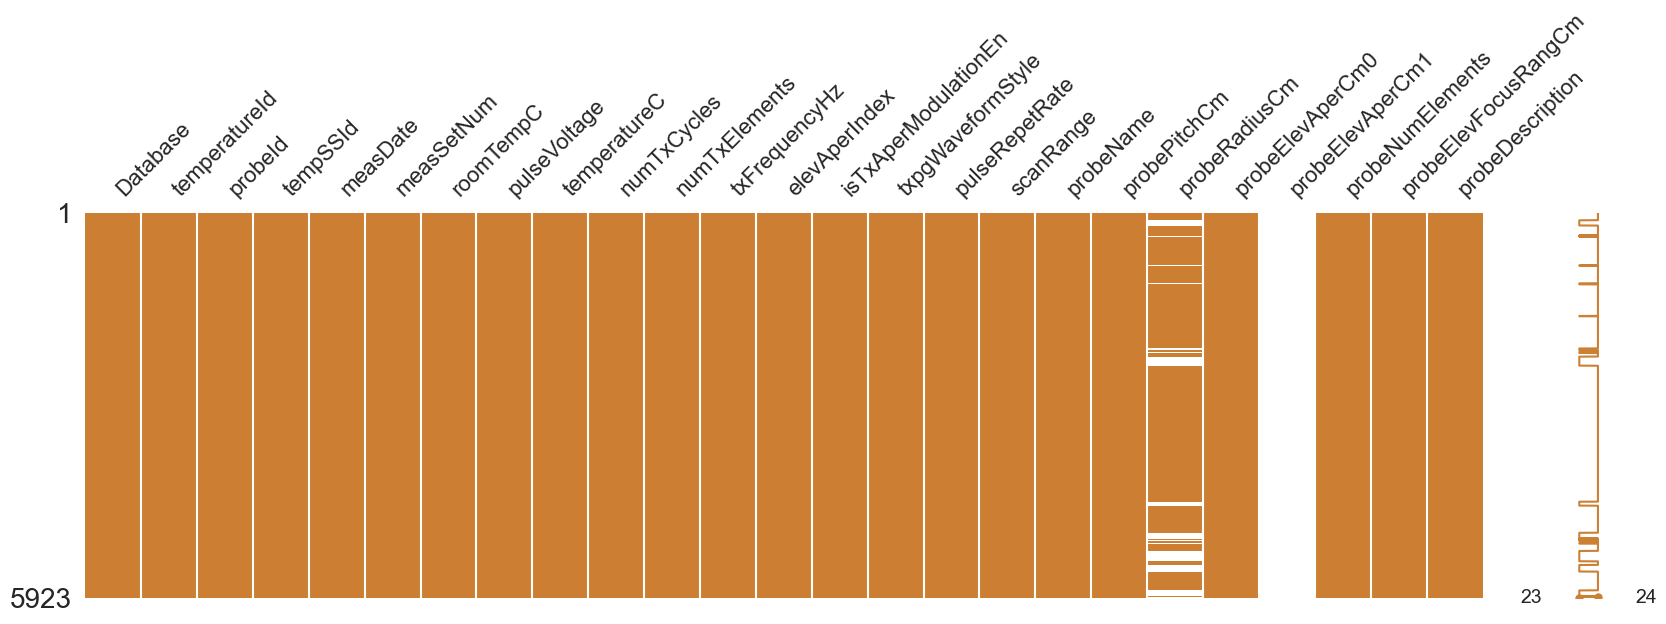

In [1146]:
## Null 데이터를 시각화하여 보여준다.
msno.matrix(df=AOP_data, figsize=(20,5), color=(0.8, 0.5, 0.2))

---
>#### 3) 데이터 parameter 전략을 어떻게 가지고 갈 것 인지?
- a) probeRadiusCm [NULL] 데이터 --> [0]으로 변경
- b) probeElevAperCm1 컬럼 데이터 전부 삭제 --> 전부 NULL 데이터이기에 삭제
- c) probeDescription 명확하게 구분화
      - Curved, Convex, Linear, Phased
- d) measDate는 필요없어 보임
- e) probeName 역시 필요없어 보임 --> probeId로 대체
- f) Target 데이터에 대한 고민이 필요해 보임.
      - temperatureC
      - roomTempC

---
#### a) probeRadiusCm: [NULL] 데이터는 0으로 변경

<Axes: >

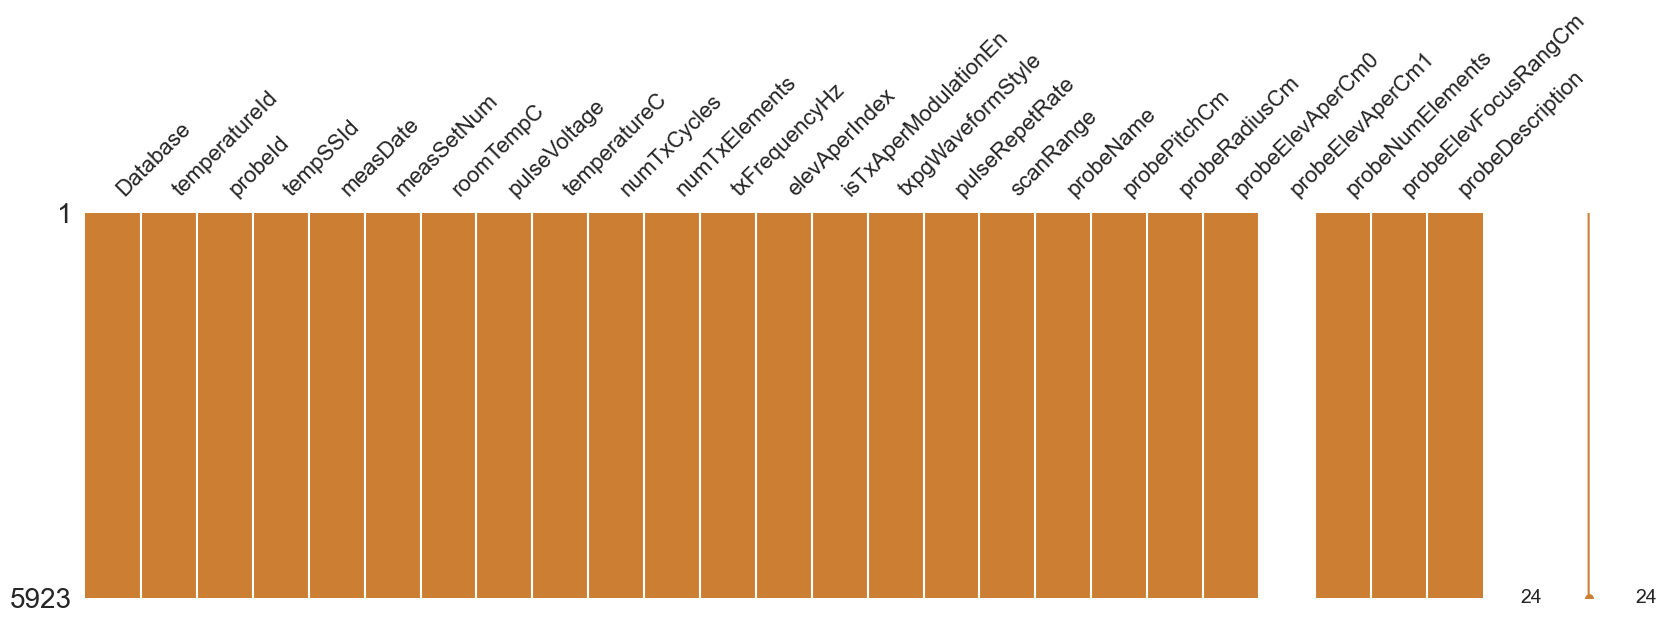

In [1147]:
AOP_data['probeRadiusCm'].fillna(0, inplace=True)
## Null 데이터를 시각화하여 보여준다.
msno.matrix(df=AOP_data, figsize=(20,5), color=(0.8, 0.5, 0.2))

---
#### b) Drop(All NULL 데이터) --> probeElevAperCm1

<Axes: >

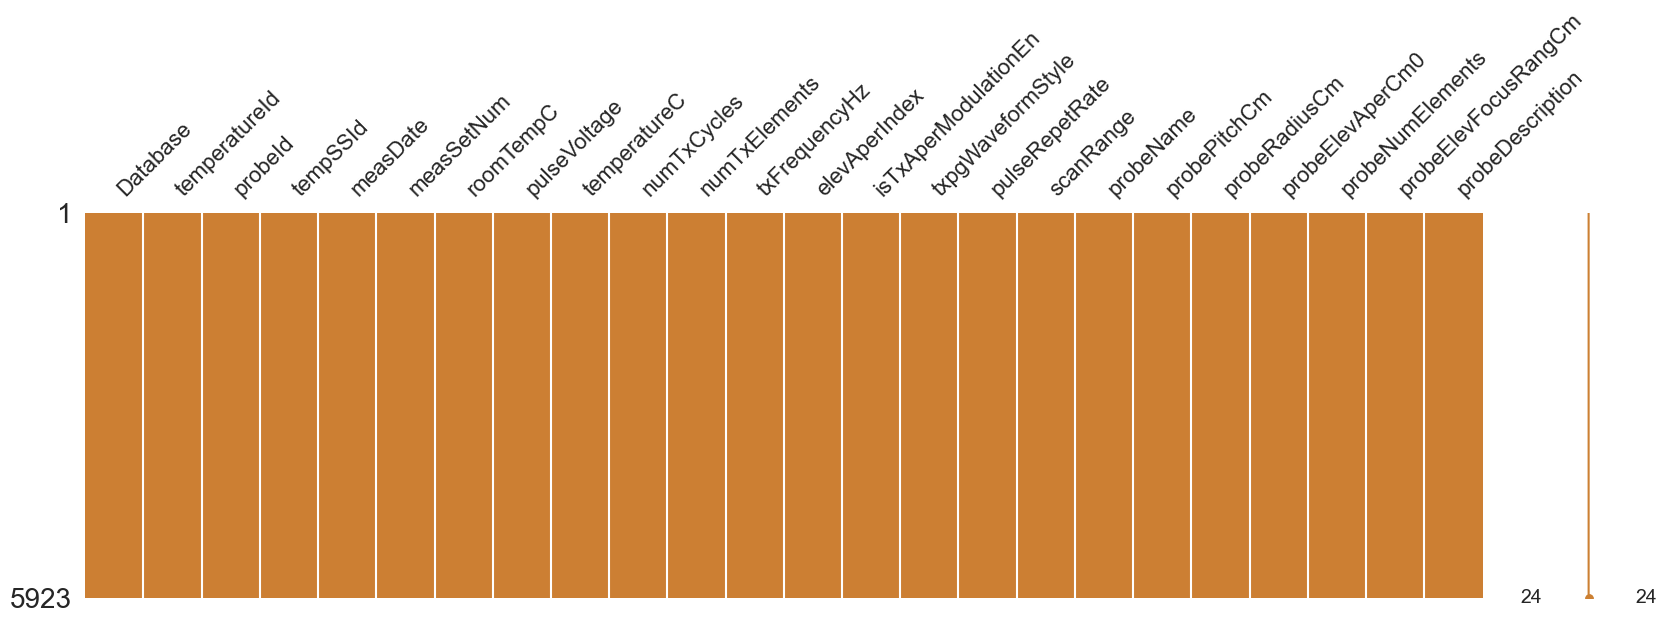

In [1148]:
AOP_data = AOP_data.drop('probeElevAperCm1', axis=1)
## Null 데이터를 시각화하여 보여준다.
msno.matrix(df=AOP_data, figsize=(20,5), color=(0.8, 0.5, 0.2))

---
#### c) probeDescription 구분을 명확하게

In [1149]:
# 열의 데이터 종류 및 갯수 확인
column_name = 'probeDescription'  # 확인하고자 하는 열의 이름
unique_values = AOP_data[column_name].unique()
value_counts = AOP_data[column_name].value_counts()

print(f"{column_name} 열의 데이터 종류: {unique_values}")
print(f"{column_name} 열의 각 데이터 갯수:\n{value_counts}")

probeDescription 열의 데이터 종류: ['Convex' 'Phased' 'Curved' 'Linear' 'AcuNav_Phased' 'Phase']
probeDescription 열의 각 데이터 갯수:
probeDescription
Convex           1796
Linear           1513
Curved           1257
Phased           1084
Phase             169
AcuNav_Phased     104
Name: count, dtype: int64


In [1150]:
AOP_data.loc[AOP_data["probeDescription"] == "Curved", "probeDescription"] = "Convex"
AOP_data.loc[AOP_data["probeDescription"] == "Phased", "probeDescription"] = "Phase"
AOP_data.loc[AOP_data["probeDescription"] == "AcuNav_Phased", "probeDescription"] = "Phase"

# 열의 데이터 종류 및 갯수 확인
column_name = 'probeDescription'  # 확인하고자 하는 열의 이름
unique_values = AOP_data[column_name].unique()
value_counts = AOP_data[column_name].value_counts()

print(f"{column_name} 열의 데이터 종류: {unique_values}")
print(f"{column_name} 열의 각 데이터 갯수:\n{value_counts}")
print(len(AOP_data[column_name]))

probeDescription 열의 데이터 종류: ['Convex' 'Phase' 'Linear']
probeDescription 열의 각 데이터 갯수:
probeDescription
Convex    3053
Linear    1513
Phase     1357
Name: count, dtype: int64
5923


---
#### d)-e) measDate / probeName 필요없어서 Drop

<Axes: >

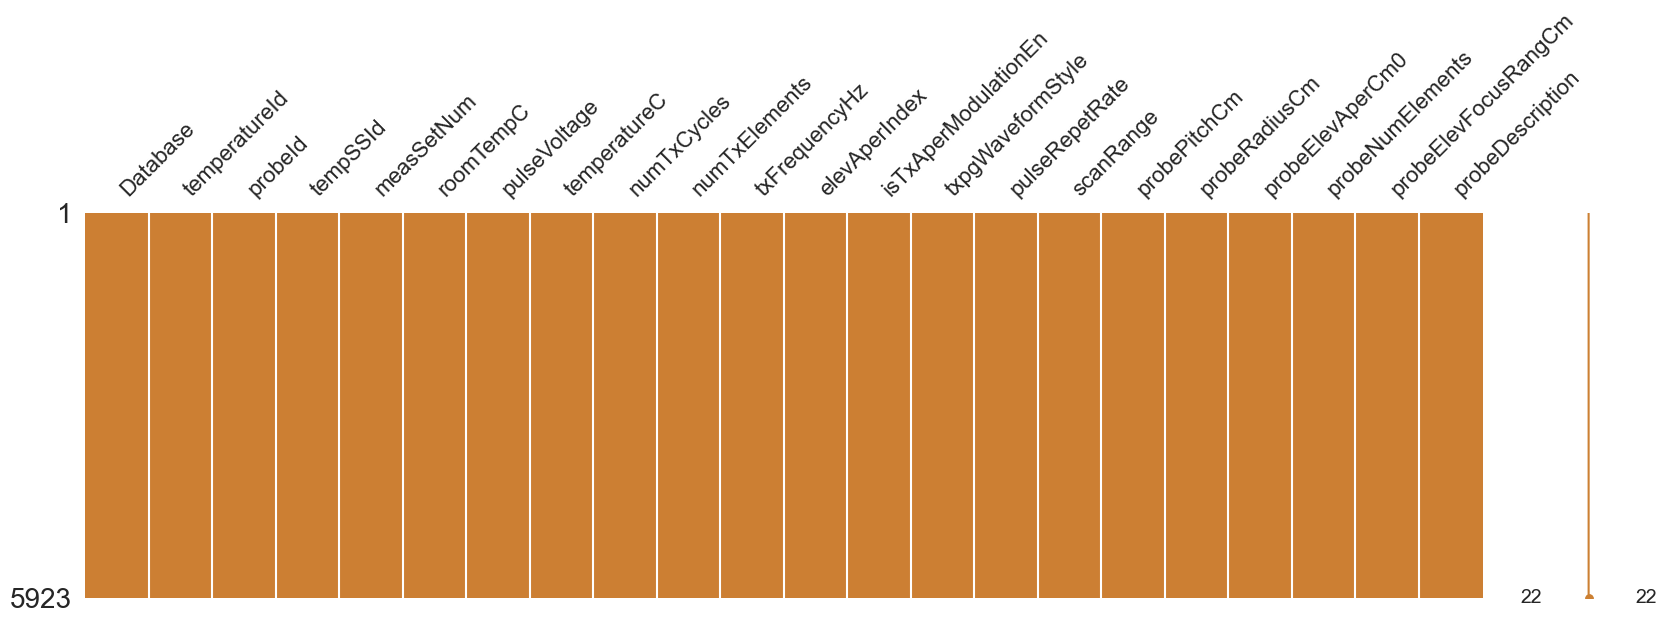

In [1151]:
AOP_data = AOP_data.drop(["measDate", "probeName"], axis=1)
## Null 데이터를 시각화하여 보여준다.
msno.matrix(df=AOP_data, figsize=(20,5), color=(0.8, 0.5, 0.2))

---
#### f) Target 데이터 분석

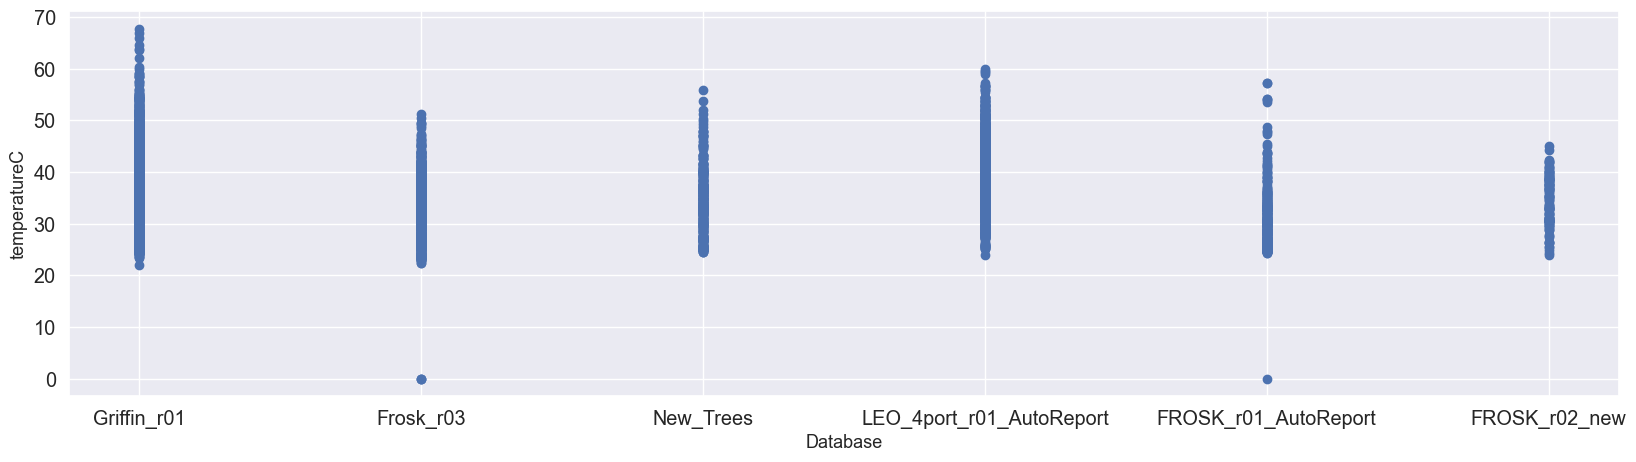

In [1152]:
fig, axs = plt.subplots(figsize=(20, 5))
axs.scatter(x = AOP_data['Database'], y = AOP_data['temperatureC'])
plt.xlabel('Database', fontsize=13)
plt.ylabel('temperatureC', fontsize=13)
plt.show()

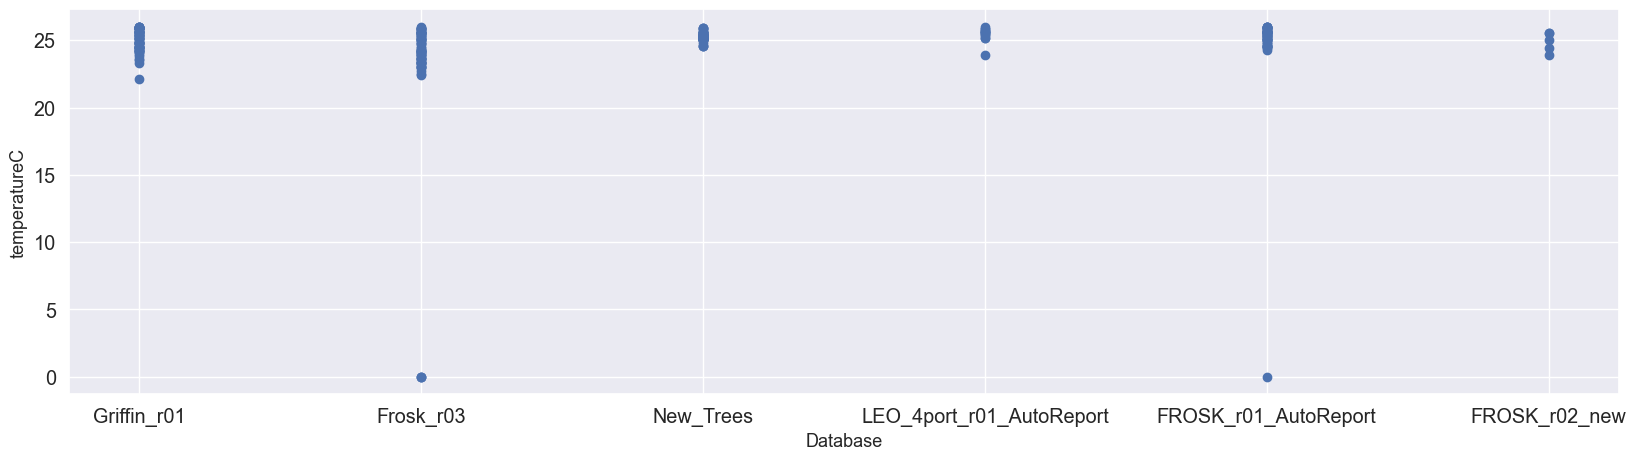

In [1153]:
# temperatureC가 26도 이하인 데이터만 필터링
filtered_data = AOP_data[AOP_data['temperatureC'] <= 26]

fig, axs = plt.subplots(figsize=(20, 5))
axs.scatter(x=filtered_data['Database'], y=filtered_data['temperatureC'])
plt.xlabel('Database', fontsize=13)
plt.ylabel('temperatureC', fontsize=13)
plt.show()

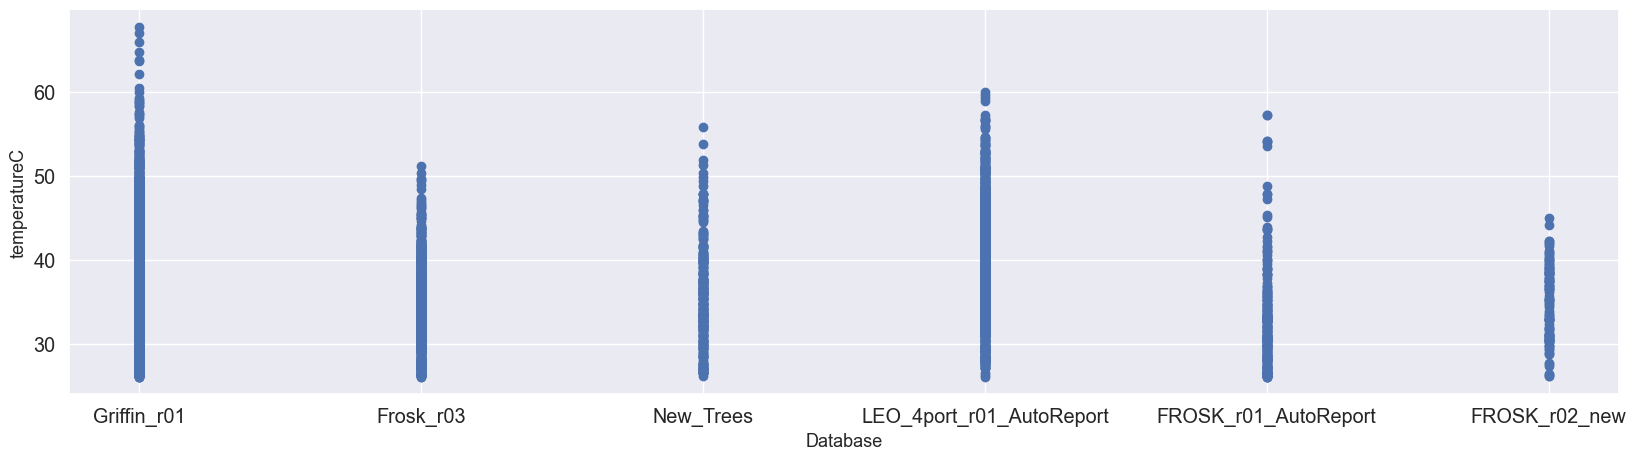

In [1154]:
# temperatureC가 26도 이상인 행만 선택
AOP_data = AOP_data[AOP_data['temperatureC'] > 26]

fig, axs = plt.subplots(figsize=(20, 5))
axs.scatter(x=AOP_data['Database'], y=AOP_data['temperatureC'])
plt.xlabel('Database', fontsize=13)
plt.ylabel('temperatureC', fontsize=13)
plt.show()

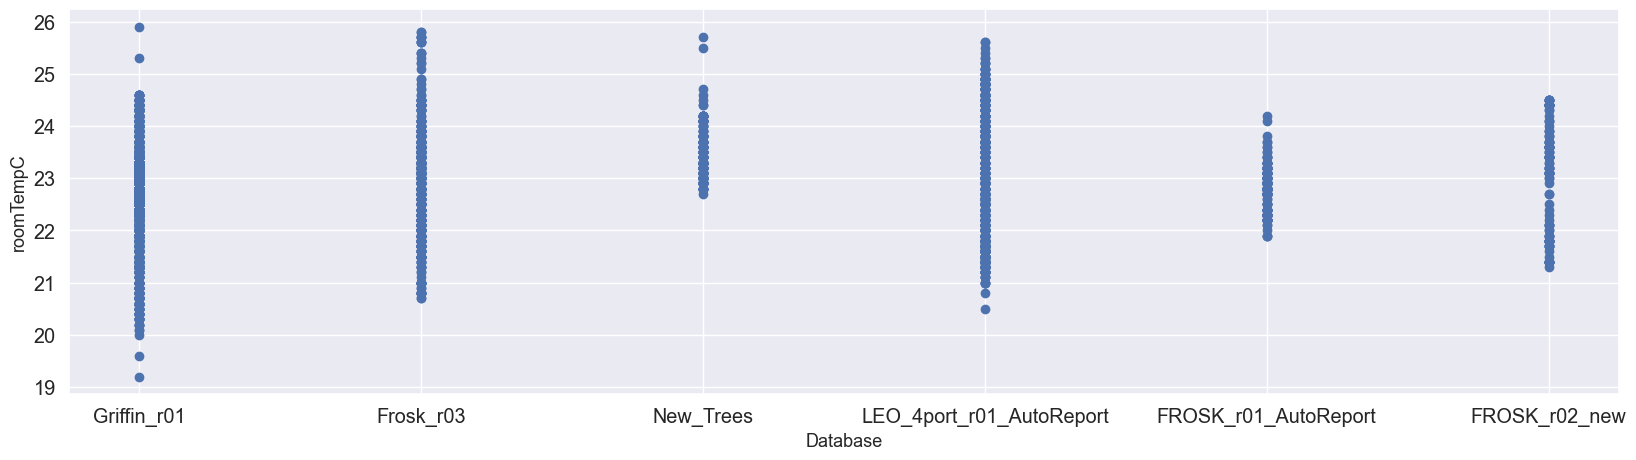

In [1155]:
AOP_data = AOP_data[AOP_data['roomTempC'] < 26]

fig, axs = plt.subplots(figsize=(20, 5))
axs.scatter(x=AOP_data['Database'], y=AOP_data['roomTempC'])
plt.xlabel('Database', fontsize=13)
plt.ylabel('roomTempC', fontsize=13)
plt.show()

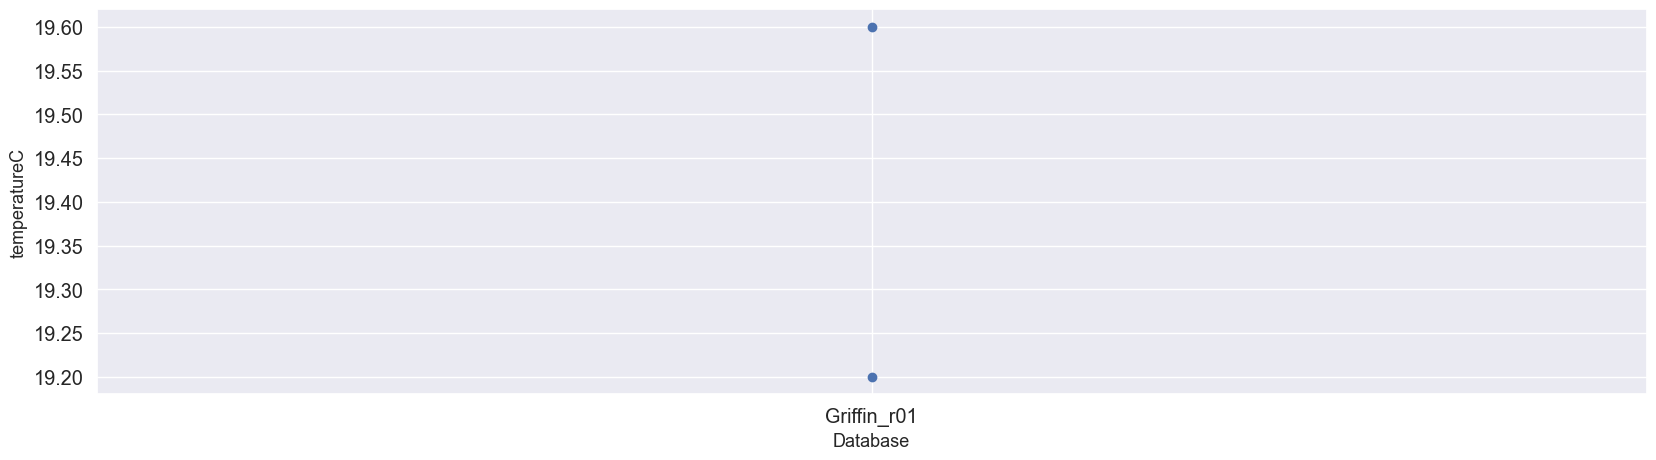

In [1156]:
# room-temperatureC가 20도 이하인 데이터만 필터링
below_20 = AOP_data[AOP_data['roomTempC'] < 20]

fig, axs = plt.subplots(figsize=(20, 5))
axs.scatter(x=below_20['Database'], y=below_20['roomTempC'])
plt.xlabel('Database', fontsize=13)
plt.ylabel('temperatureC', fontsize=13)
plt.show()

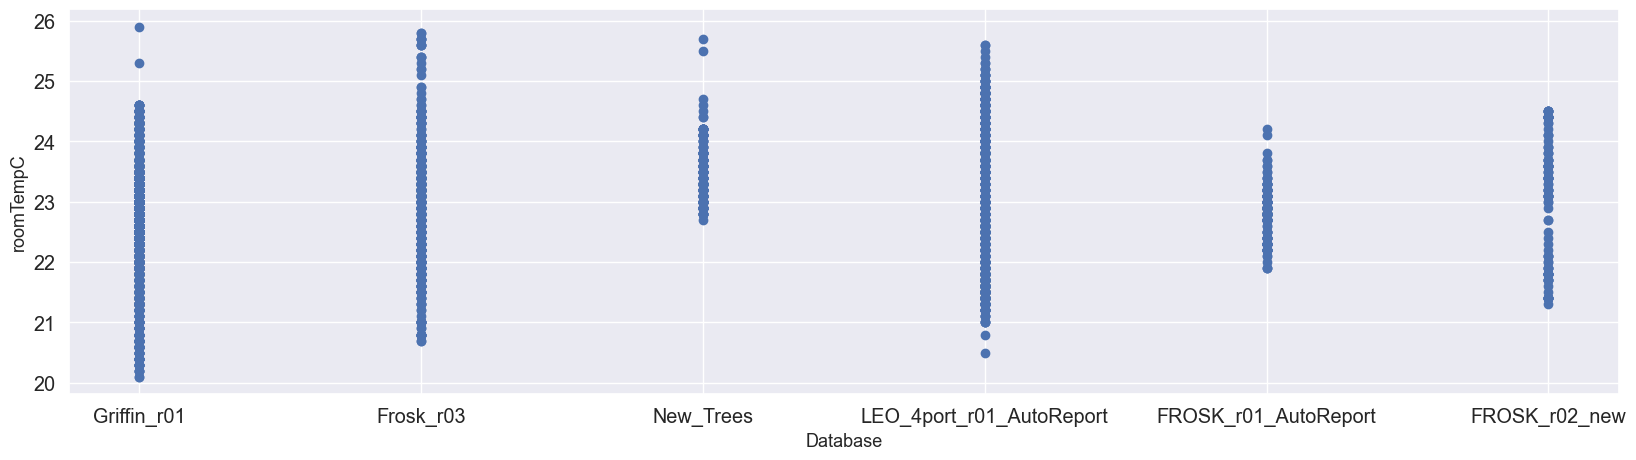

In [1157]:
AOP_data = AOP_data[AOP_data['roomTempC'] > 20]

fig, axs = plt.subplots(figsize=(20, 5))
axs.scatter(x=AOP_data['Database'], y=AOP_data['roomTempC'])
plt.xlabel('Database', fontsize=13)
plt.ylabel('roomTempC', fontsize=13)
plt.show()

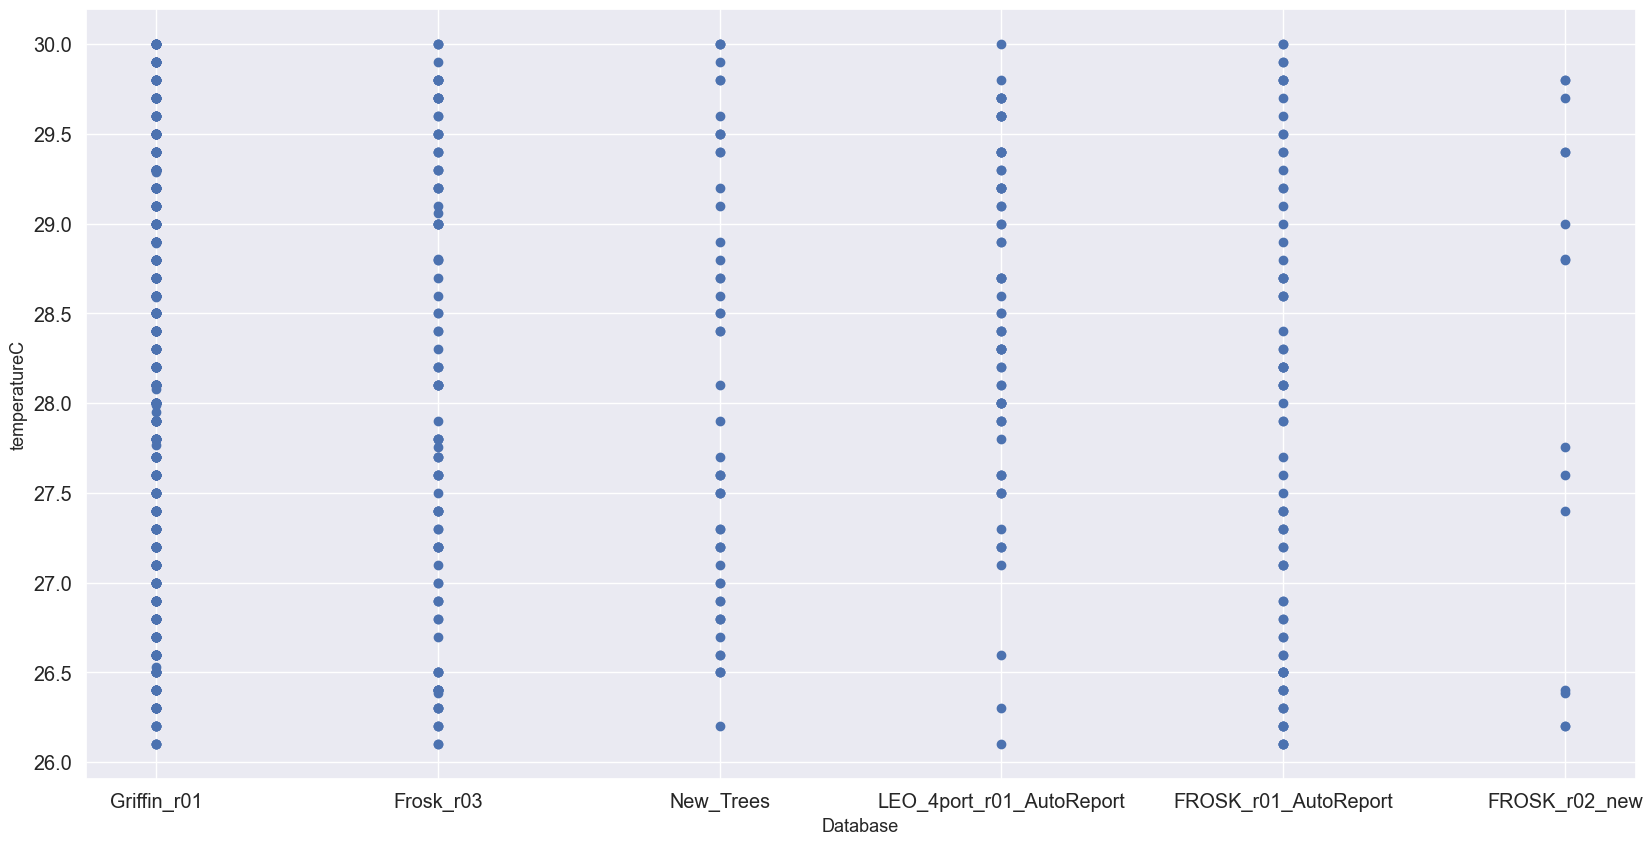

In [1158]:
# temperatureC가 26도 이하인 데이터만 필터링
filtered_data = AOP_data[AOP_data['temperatureC'] <= 30]

fig, axs = plt.subplots(figsize=(20, 10))
axs.scatter(x=filtered_data['Database'], y=filtered_data['temperatureC'])
plt.xlabel('Database', fontsize=13)
plt.ylabel('temperatureC', fontsize=13)
plt.show()

---
#### f) Target 데이터의 분석
- temperatureC - roomTempC 분석
- histogram이용하여 분석
- Skewness / 왜도
    - symmetrical bell curve 혹은 normal distribution에서 왜곡 정도를 말한다. 데이터 분포의 대칭성이 얼마나 결핍되었는지를 측정한다. 완전히 대칭인 분포는 skewness가 0이다.
    - 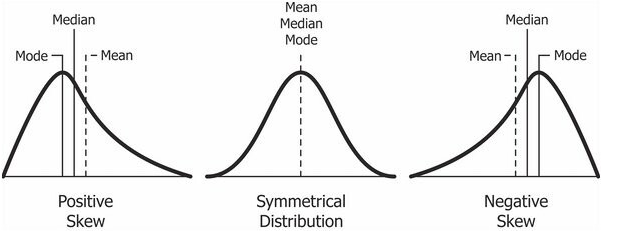

---
#### 확률 및 분포

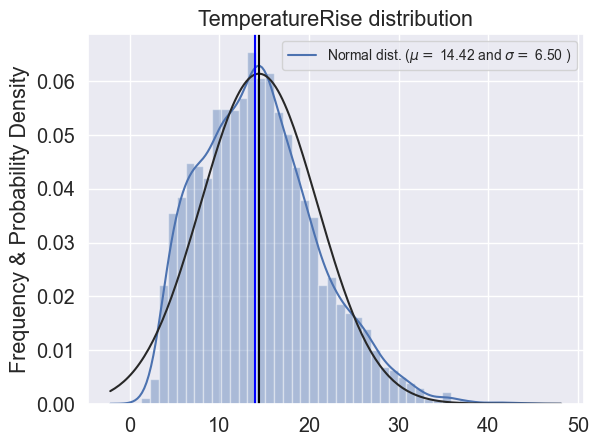

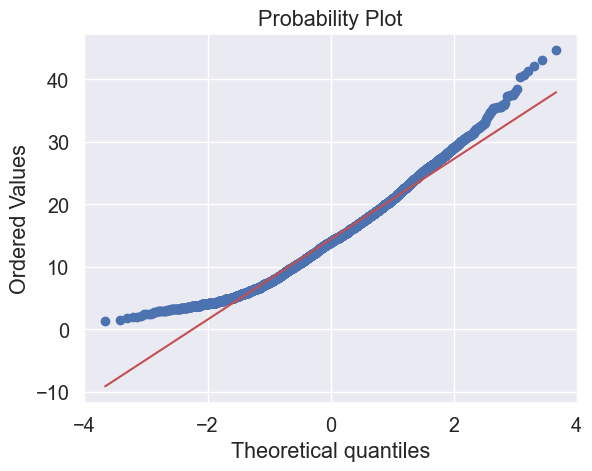

Skewness & TempRise: 0.578394
Kurtosis & TempRise: 0.238253


In [1159]:
TemperatureRise = (AOP_data['temperatureC'] - AOP_data['roomTempC'])

sns.distplot(TemperatureRise , fit=norm)

## Get the fitted parameters used by the function
(mu, sigma) = norm.fit(TemperatureRise)

## Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best', fontsize=10)
plt.ylabel('Frequency & Probability Density')
plt.title('TemperatureRise distribution')

## TemperatureRise mean and median value display
plt.axvline(TemperatureRise.mean(), color='black')
plt.axvline(TemperatureRise.median(), color='blue')

## Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(TemperatureRise, plot=plt)
plt.show()

#skewness and kurtosis
print("Skewness & TempRise: %f" % TemperatureRise.skew())
print("Kurtosis & TempRise: %f" % TemperatureRise.kurt())

---
#### Temperature 분석

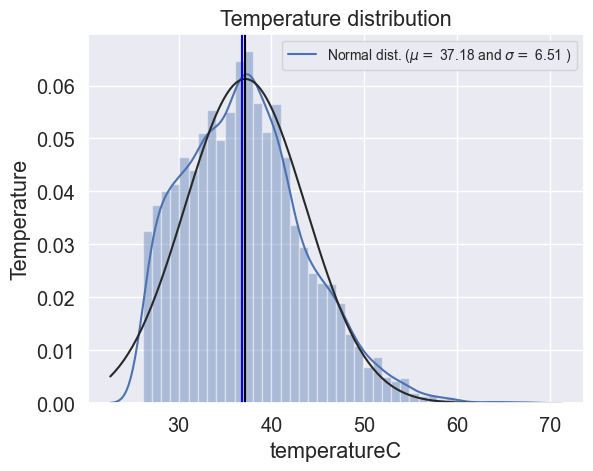

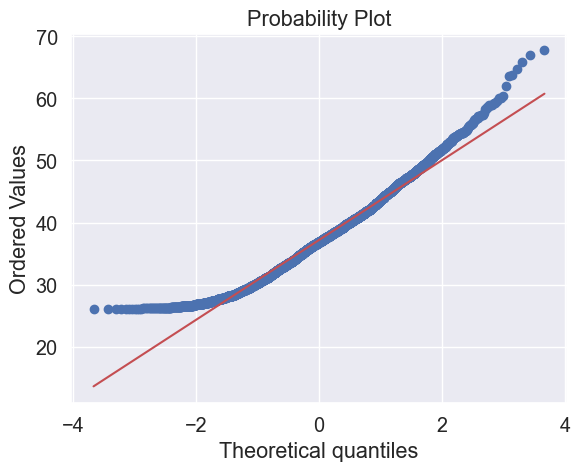

Skewness & Temp: 0.558512
Kurtosis & Temp: 0.237210


In [1160]:
Temperature = (AOP_data['temperatureC'])

sns.distplot(Temperature , fit=norm);

## Get the fitted parameters used by the function
(mu, sigma) = norm.fit(Temperature)

## Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best', fontsize=10)
plt.ylabel('Temperature')
plt.title('Temperature distribution')

## Temperature mean and median value display
plt.axvline(Temperature.mean(), color='black')
plt.axvline(Temperature.median(), color='blue')

## Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(Temperature, plot=plt)
plt.show()

#skewness and kurtosis
print("Skewness & Temp: %f" % Temperature.skew())
print("Kurtosis & Temp: %f" % Temperature.kurt())

---
#### log transform 변환하여 확인하기(TemperatureRise)

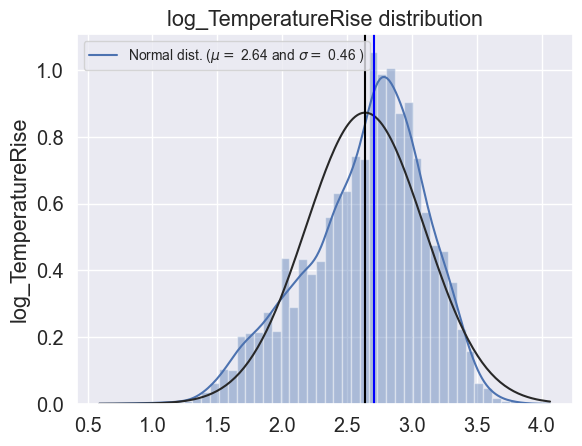

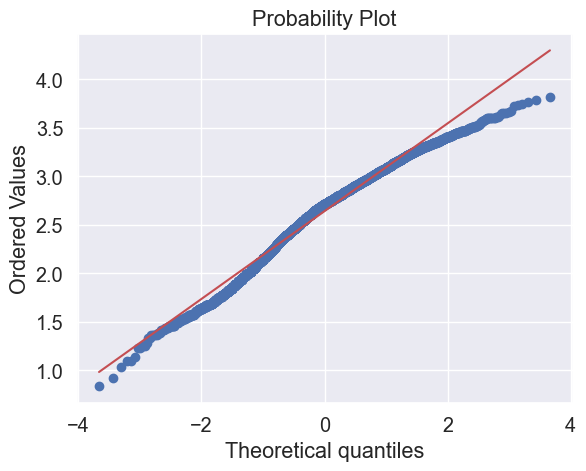

Skewness & TempRise: -0.496486
Kurtosis & TempRise: -0.143486


In [1161]:
log_temp_rise = np.log1p(TemperatureRise)

sns.distplot(log_temp_rise , fit=norm)

## Get the fitted parameters used by the function
(mu, sigma) = norm.fit(log_temp_rise)

## Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best', fontsize=10)
plt.ylabel('log_TemperatureRise')
plt.title('log_TemperatureRise distribution')

## TemperatureRise mean and median value display
plt.axvline(log_temp_rise.mean(), color='black')
plt.axvline(log_temp_rise.median(), color='blue')

## Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(log_temp_rise, plot=plt)
plt.show()

#skewness and kurtosis
print("Skewness & TempRise: %f" % log_temp_rise.skew())
print("Kurtosis & TempRise: %f" % log_temp_rise.kurt())

#### log transform 변환하여 확인하기(temperatureC)

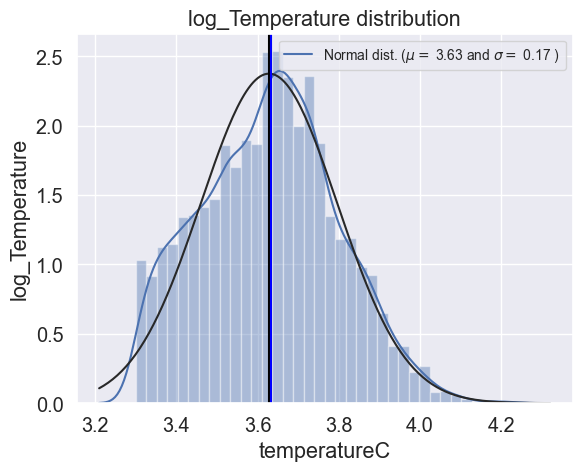

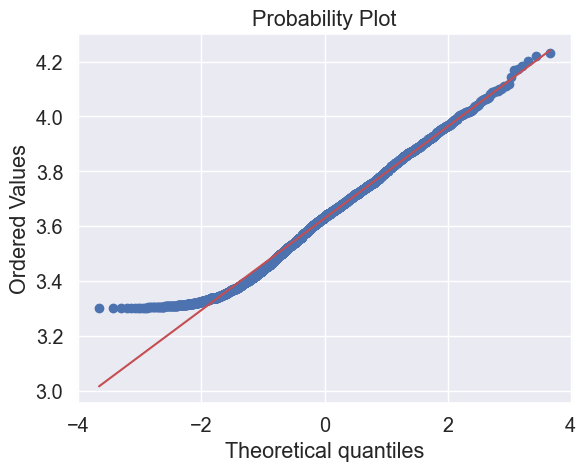

Skewness & Temp: 0.136758
Kurtosis & Temp: -0.431622


In [1162]:
log_temp = np.log1p(Temperature)

sns.distplot(log_temp , fit=norm)

## Get the fitted parameters used by the function
(mu, sigma) = norm.fit(log_temp)

## Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best', fontsize=10)
plt.ylabel('log_Temperature')
plt.title('log_Temperature distribution')

## TemperatureRise mean and median value display
plt.axvline(log_temp.mean(), color='black')
plt.axvline(log_temp.median(), color='blue')

## Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(log_temp, plot=plt)
plt.show()

#skewness and kurtosis
print("Skewness & Temp: %f" % log_temp.skew())
print("Kurtosis & Temp: %f" % log_temp.kurt())

### 3. Feature engineering(특성공학)
>#### 1) Relationship with numerical variables

##### Targer vs. pulseRepetRate

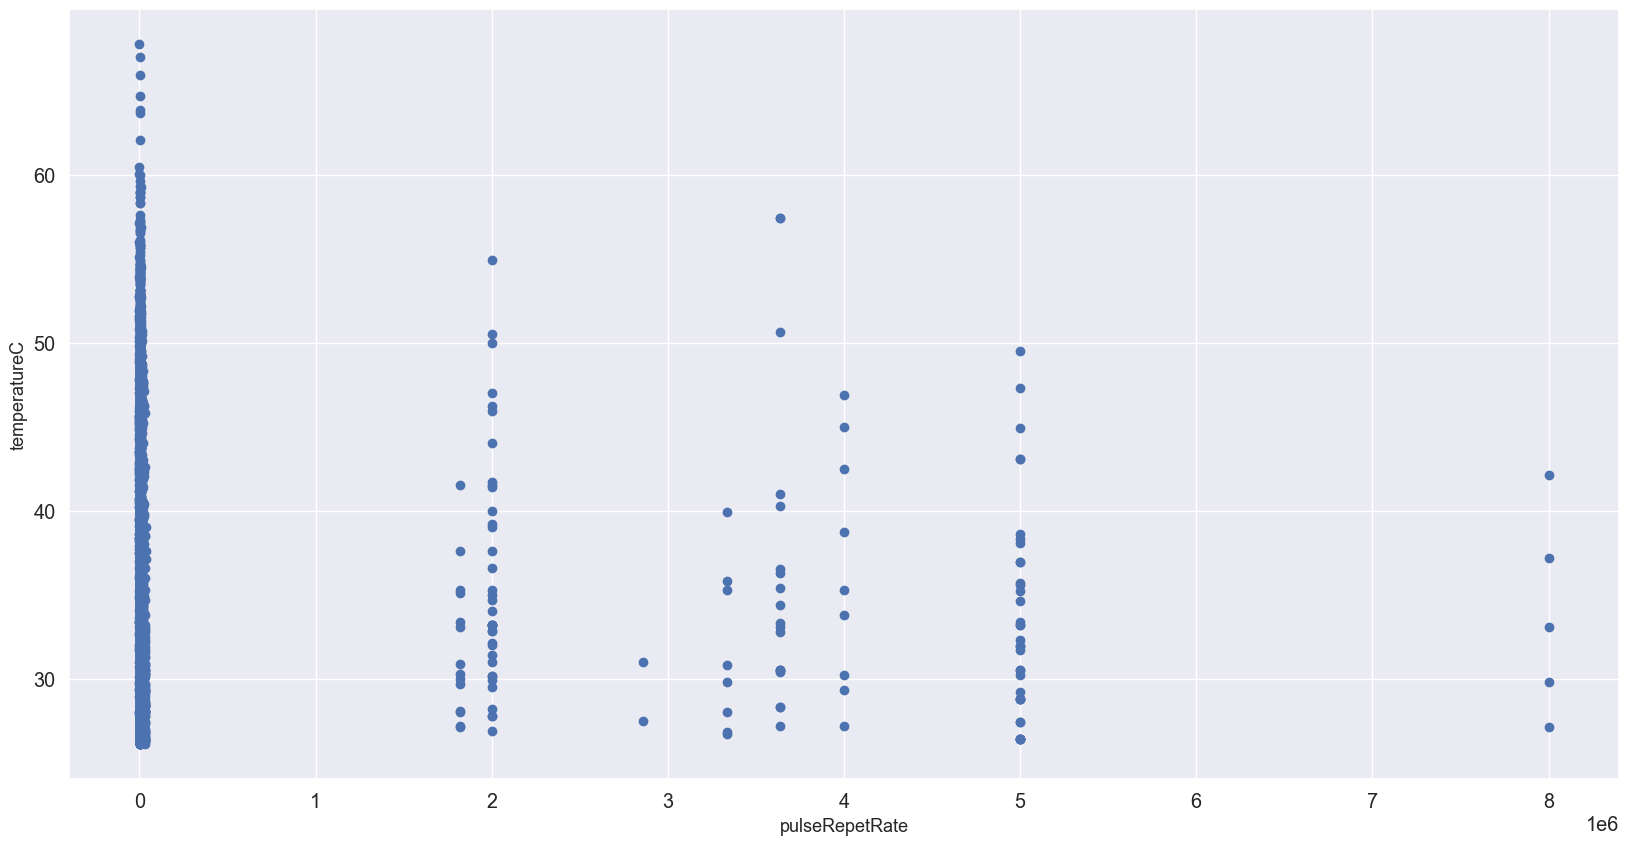

In [1163]:
fig, axs = plt.subplots(figsize=(20, 10))
axs.scatter(x = AOP_data['pulseRepetRate'], y = AOP_data['temperatureC'])
plt.xlabel('pulseRepetRate', fontsize=13)
plt.ylabel('temperatureC', fontsize=13)

plt.show()

In [1164]:
print(AOP_data['pulseRepetRate'].unique())
print(AOP_data['pulseRepetRate'].value_counts())
print('pulseRepetRate 종류 갯수:', AOP_data['pulseRepetRate'].nunique())
print('-----')

over_1MHz = AOP_data[AOP_data['pulseRepetRate']>1000000]
print(over_1MHz['pulseRepetRate'].value_counts())

[2687.         1810.52001953 1219.94995117 ... 2770.43994141 1505.69995117
 3434.07006836]
pulseRepetRate
3.000000e+04    71
2.000000e+06    38
5.000000e+06    36
4.000000e+03    30
3.633720e+03    26
                ..
3.614100e+03     1
1.924460e+03     1
1.024740e+03     1
5.223000e+03     1
3.434070e+03     1
Name: count, Length: 3651, dtype: int64
pulseRepetRate 종류 갯수: 3651
-----
pulseRepetRate
2000000.0    38
5000000.0    36
3636400.0    19
1818200.0    14
4000000.0     9
3333300.0     8
8000000.0     5
2857100.0     2
Name: count, dtype: int64


##### CW관련 데이터 삭제(pulseRepetRate > 1000000)

In [1165]:
# pulseRepetRate 1000000 이상일 경우, 행 삭제
AOP_data = AOP_data[AOP_data['pulseRepetRate'] < 1000000]

over_1MHz = AOP_data[AOP_data['pulseRepetRate']>1000000]
print(over_1MHz['pulseRepetRate'].value_counts())

Series([], Name: count, dtype: int64)


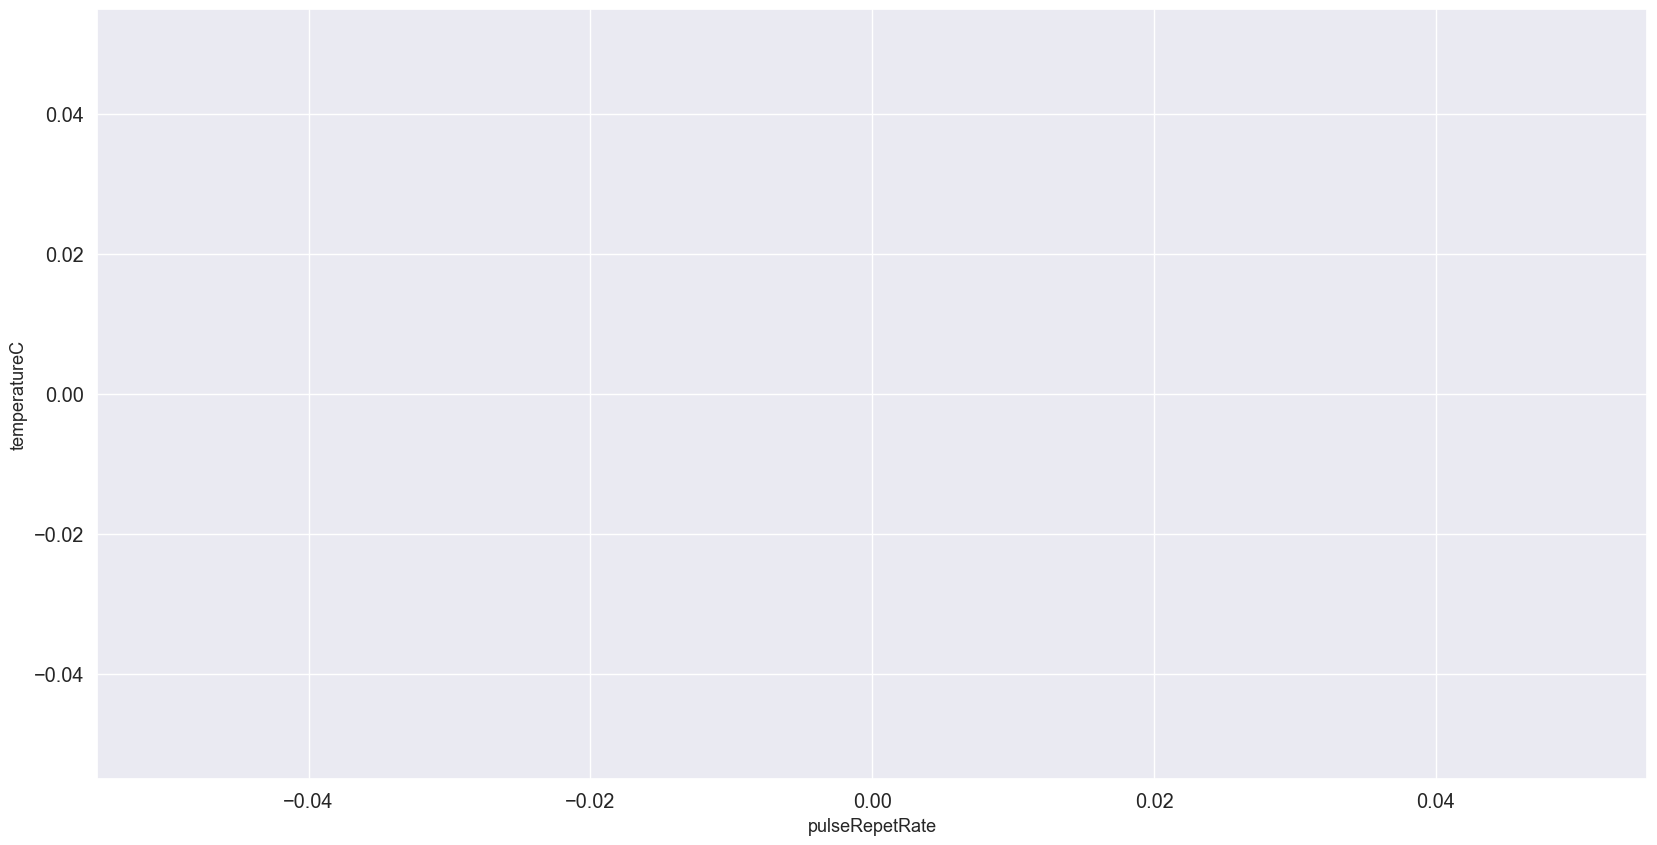

In [1166]:
## 100Hz 미만의 데이터가 있는지 확인
below_100Hz = AOP_data[AOP_data['pulseRepetRate']<100]

fig, axs = plt.subplots(figsize=(20, 10))
axs.scatter(x = below_100Hz['pulseRepetRate'], y = below_100Hz['temperatureC'])
plt.xlabel('pulseRepetRate', fontsize=13)
plt.ylabel('temperatureC', fontsize=13)

plt.show()

##### Target vs. NumTxCycles

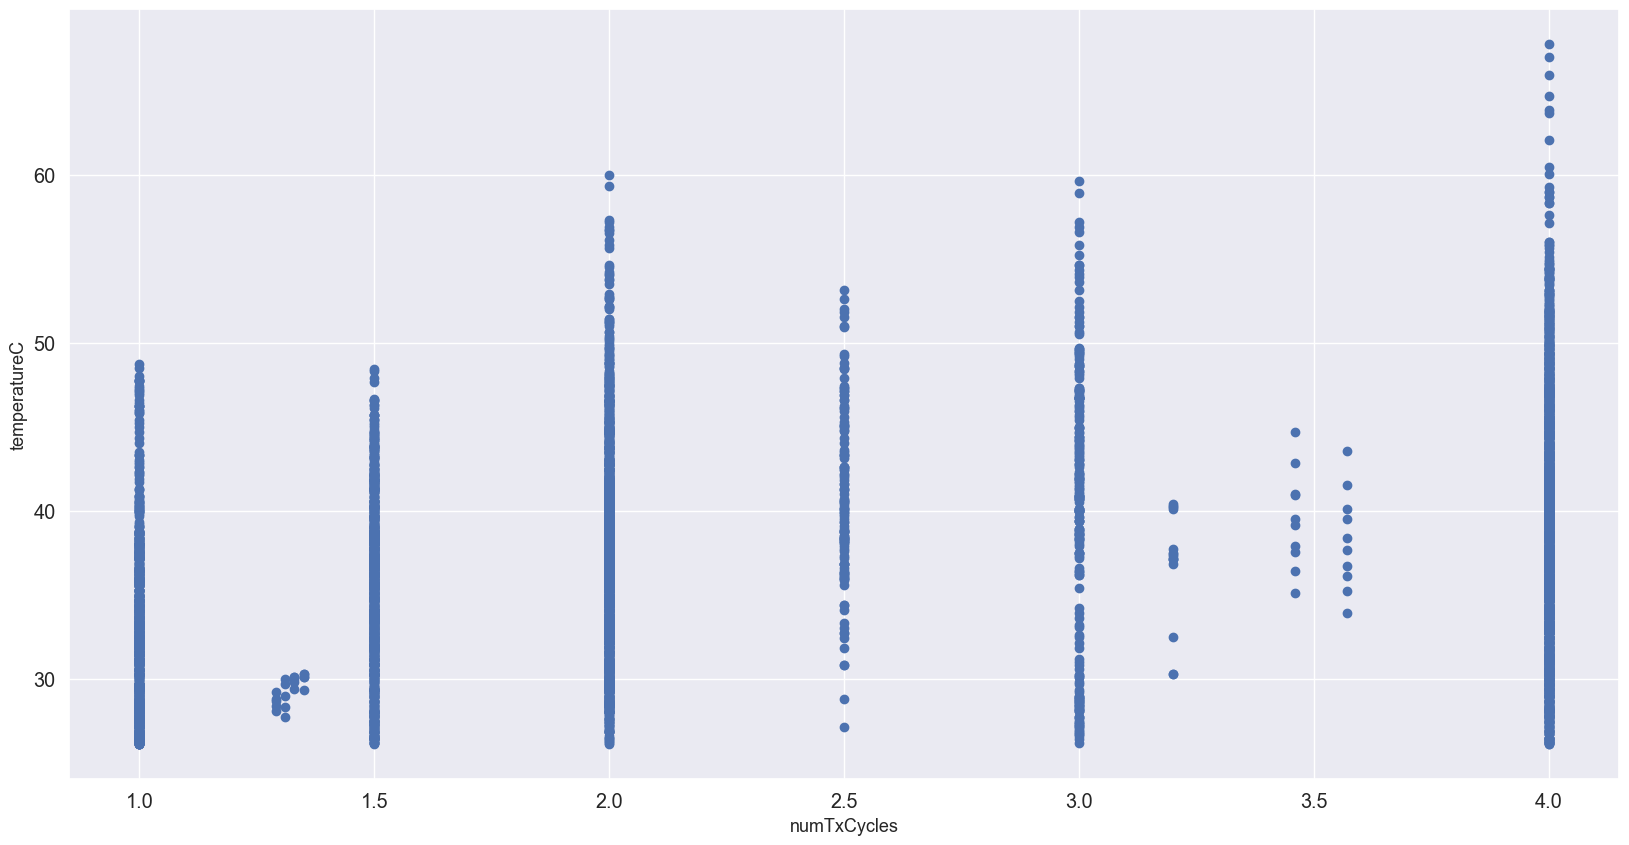

In [1167]:
fig, axs = plt.subplots(figsize=(20,10))
axs.scatter(x = AOP_data['numTxCycles'], y = AOP_data['temperatureC'])
plt.xlabel('numTxCycles', fontsize=13)
plt.ylabel('temperatureC', fontsize=13)

plt.show()

##### Target vs. txFrequencyHz

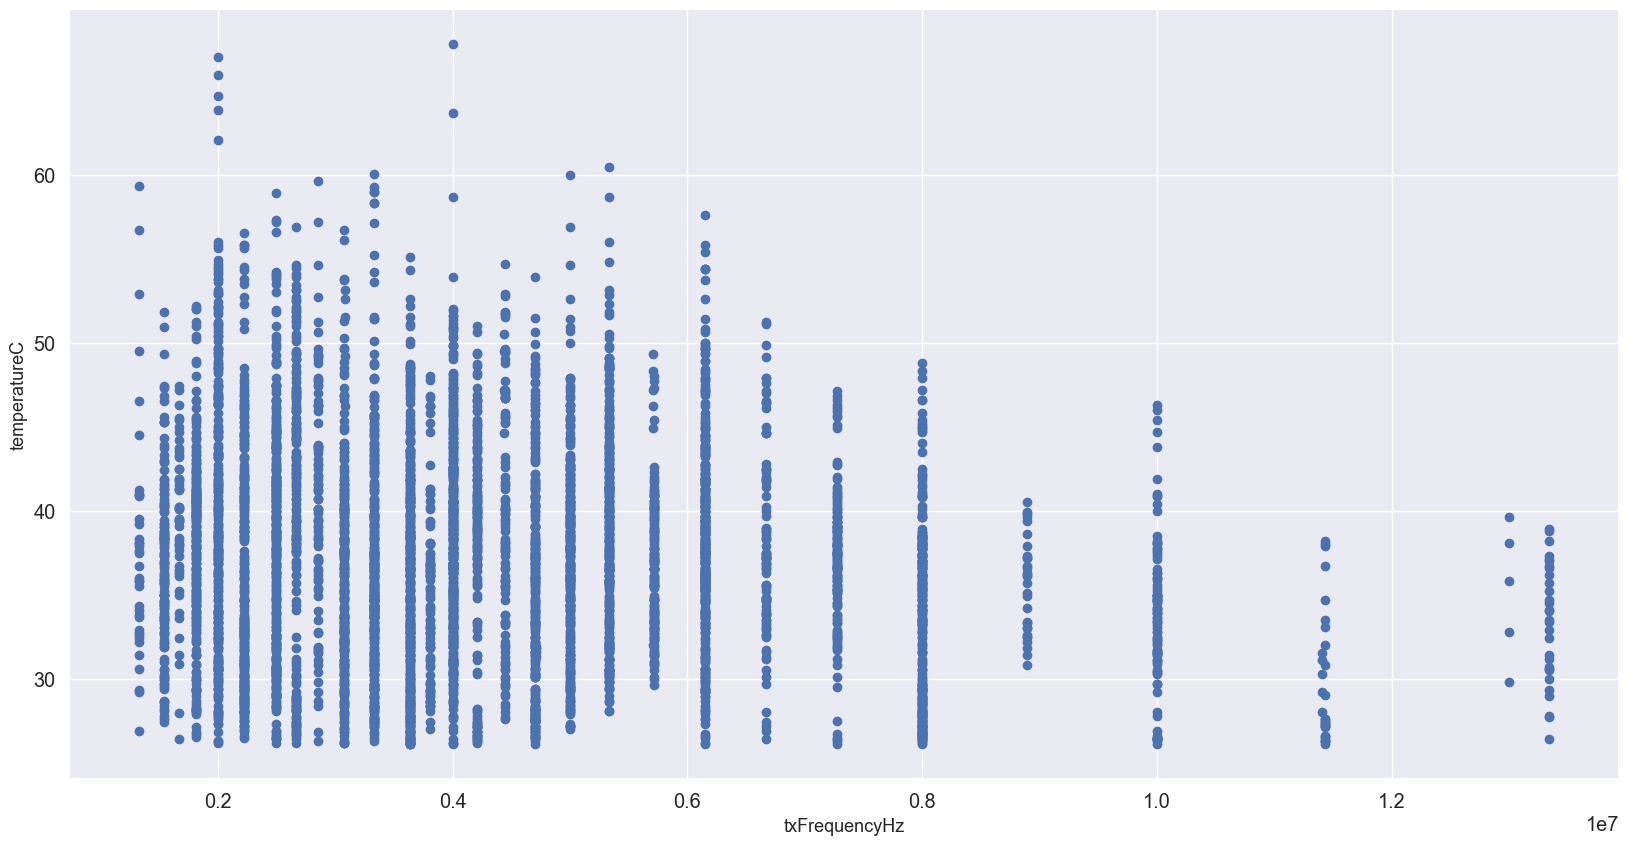

In [1168]:
fig, axs = plt.subplots(figsize=(20, 10))
axs.scatter(x = AOP_data['txFrequencyHz'], y = AOP_data['temperatureC'])
plt.xlabel('txFrequencyHz', fontsize=13)
plt.ylabel('temperatureC', fontsize=13)

plt.show()

##### Target vs. voltage

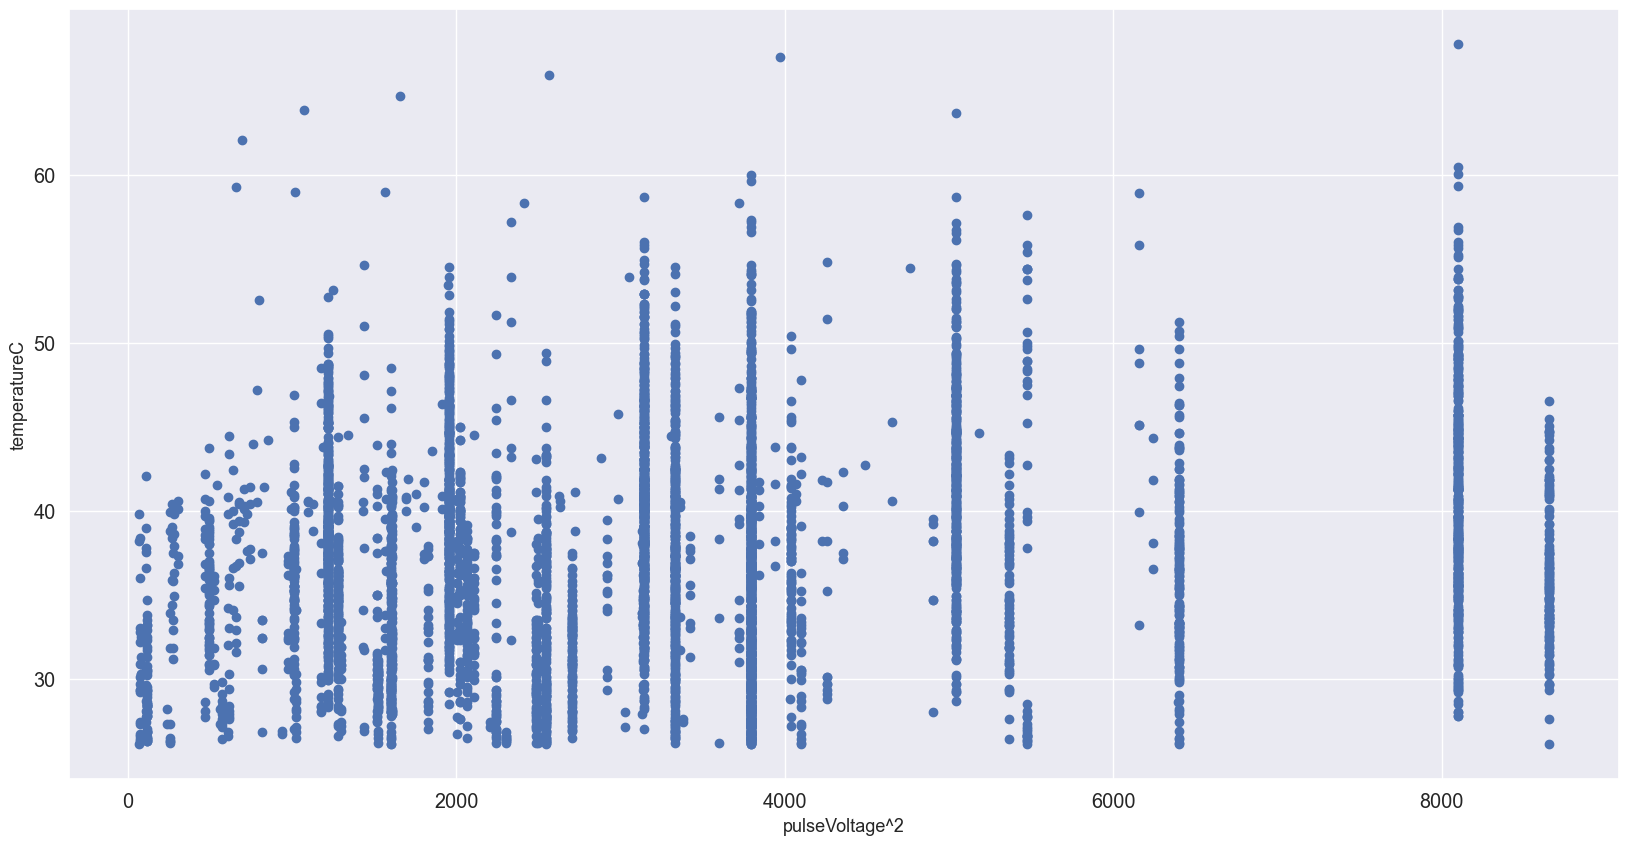

In [1169]:
fig, axs = plt.subplots(figsize=(20, 10))
axs.scatter(x = AOP_data['pulseVoltage'] * AOP_data['pulseVoltage'], y = AOP_data['temperatureC'])
plt.xlabel('pulseVoltage^2', fontsize=13)
plt.ylabel('temperatureC', fontsize=13)

plt.show()

##### Target vs. Energy

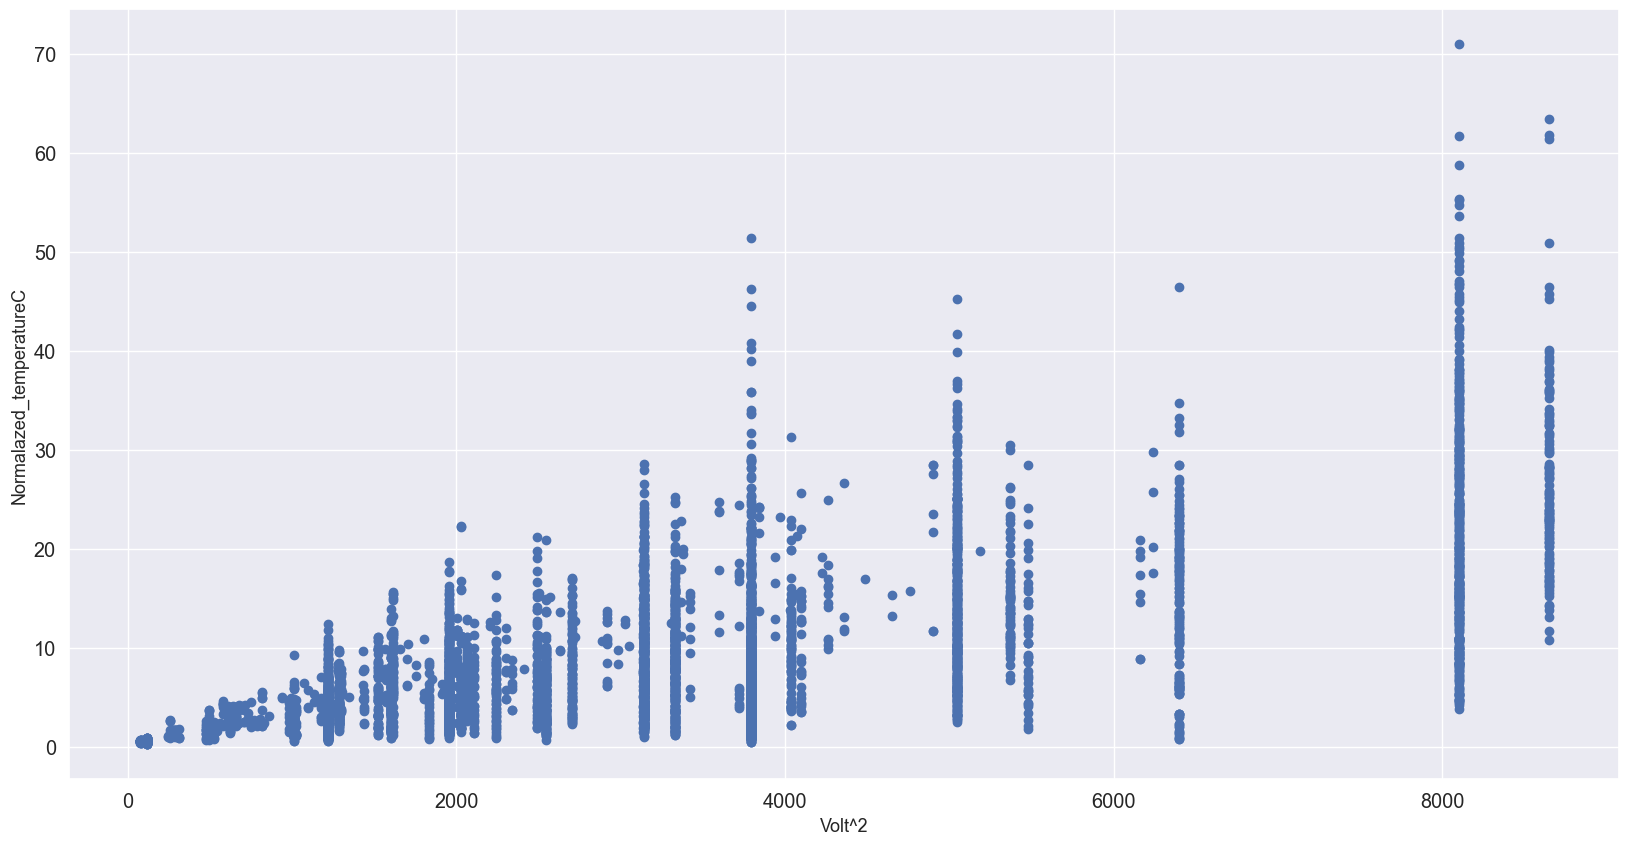

In [1170]:
AOP_data['volt2'] = AOP_data['pulseVoltage'] * AOP_data['pulseVoltage']

fig, axs = plt.subplots(figsize=(20, 10))
axs.scatter(x = AOP_data['volt2'], 
            y = (AOP_data['temperatureC']) / (AOP_data['numTxCycles'] * (AOP_data['pulseRepetRate']/1000)))
plt.xlabel('Volt^2', fontsize=13)
plt.ylabel('Normalazed_temperatureC', fontsize=13)

plt.show()

In [1171]:
# 에너지 계산
# StandardScaler 사용 후, 다시 확인이 필요.
# energy = np.array(AOP_data['pulseVoltage']) ** 2 * AOP_data['pulseRepetRate'] * AOP_data['numTxElements'] * AOP_data['probePitchCm'] * AOP_data['probeElevAperCm0']

# fig, axs = plt.subplots(figsize=(20, 10))
# axs.loglog(energy, AOP_data['temperatureC'], 'o')

# axs.set_xlabel('Energy (log scale)', fontsize=13)
# axs.set_ylabel('Temperature (C)', fontsize=13)
# axs.set_title('Energy vs Temperature (Log-Log Scale)')

# plt.tight_layout()
# plt.show()

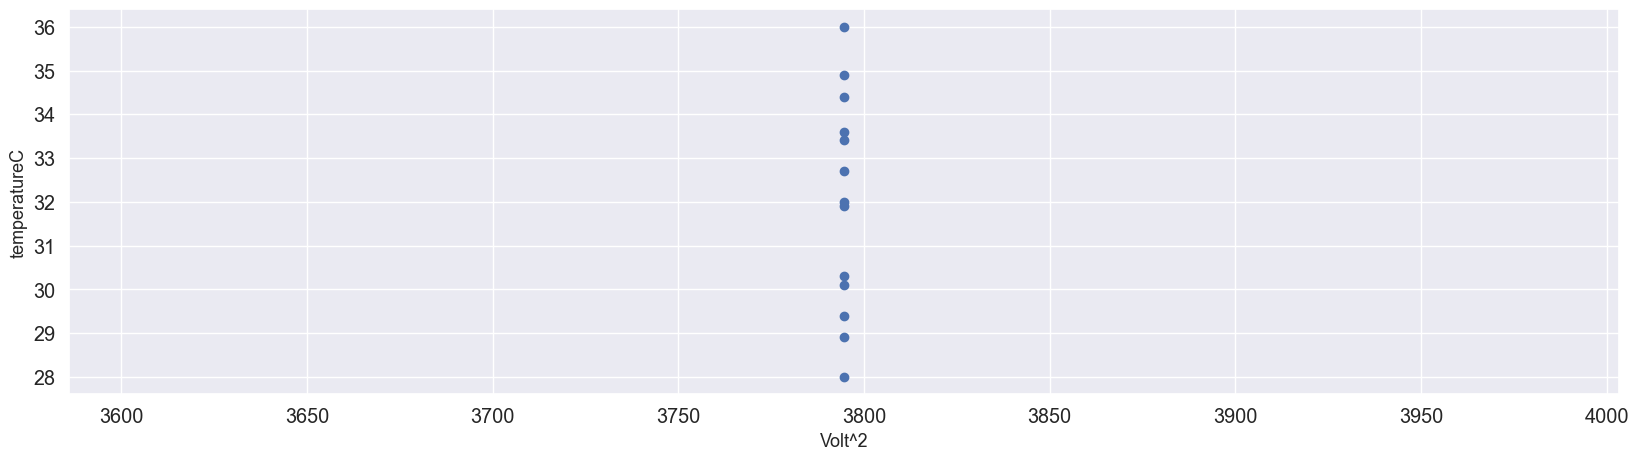

In [1172]:
outlier = AOP_data[(AOP_data['volt2'] < 4000) & ((AOP_data['temperatureC']) / (AOP_data['numTxCycles'] * (AOP_data['pulseRepetRate']/1000)) > 30)] 


fig, axs = plt.subplots(figsize=(20, 5))
axs.scatter(x = outlier['volt2'], 
            y = outlier['temperatureC'])
plt.xlabel('Volt^2', fontsize=13)
plt.ylabel('temperatureC', fontsize=13)

plt.show()

In [1173]:
print(outlier.shape)
outlier.head(13)

(13, 23)


Database  temperatureId   probeId  tempSSId  measSetNum  roomTempC  \
81    Griffin_r01            692  11284923       784           3  23.900000   
87    Griffin_r01            700  11284923       784           3  23.900000   
89    Griffin_r01            703  11284923       784           3  23.900000   
93    Griffin_r01            709  11284923       784           3  23.799999   
95    Griffin_r01            712  11284923       784           3  23.799999   
97    Griffin_r01            714  11284923       784           3  23.799999   
98    Griffin_r01            716  11284923       784           3  23.799999   
1383  Griffin_r01           5279  11370949      5147           3  21.500000   
1384  Griffin_r01           5280  11370949      5147           3  21.299999   
1388  Griffin_r01           5284  11370949      5147           3  21.400000   
1389  Griffin_r01           5285  11370949      5147           3  21.200001   
1390  Griffin_r01           5286  11370949      5147           3  21.200001   
1391  Griffin_r01           5287  11370949      5147           3  21.299999   

      pulseVoltage  temperatureC  numTxCycles  numTxElements  ...  \
81       61.599998     33.599998          1.5             64  ...   
87       61.599998     33.400002          1.5             96  ...   
89       61.599998     34.900002          1.5             96  ...   
93       61.599998     32.000000          1.5            128  ...   
95       61.599998     32.700001          1.5            128  ...   
97       61.599998     34.400002          1.5            128  ...   
98       61.599998     36.000000          1.5            128  ...   
1383     61.599998     29.400000          2.0             48  ...   
1384     61.599998     30.299999          2.0             48  ...   
1388     61.599998     28.000000          2.0             64  ...   
1389     61.599998     28.900000          2.0             64  ...   
1390     61.599998     30.100000          2.0             64  ...   
1391     61.599998     31.900000          2.0             64  ...   

      txpgWaveformStyle  pulseRepetRate  scanRange  probePitchCm  \
81                    2      664.190002   0.132179        0.0212   
87                    2      546.570007   0.132179        0.0212   
89                    2      649.349976   0.731390        0.0212   
93                    2      415.420013   0.132179        0.0212   
95                    2      470.989990   0.731390        0.0212   
97                    2      588.510010   1.471590        0.0212   
98                    2      706.210022   2.070800        0.0212   
1383                  2      437.059998   0.000739        0.0148   
1384                  2      495.250000   0.000895        0.0148   
1388                  2      314.700012   0.000739        0.0148   
1389                  2      359.709991   0.000895        0.0148   
1390                  2      419.600006   0.004612        0.0148   
1391                  2      503.420013   0.009596        0.0148   

      probeRadiusCm  probeElevAperCm0  probeNumElements  probeElevFocusRangCm  \
81             1.48               0.5             128.0                   1.9   
87             1.48               0.5             128.0                   1.9   
89             1.48               0.5             128.0                   1.9   
93             1.48               0.5             128.0                   1.9   
95             1.48               0.5             128.0                   1.9   
97             1.48               0.5             128.0                   1.9   
98             1.48               0.5             128.0                   1.9   
1383           0.00               0.6              64.0                   5.5   
1384           0.00               0.6              64.0                   5.5   
1388           0.00               0.6              64.0                   5.5   
1389           0.00               0.6              64.0                   5.5   
1390      

##### TemperatureRise 기준으로 3도 이상 올라가지 않은 데이터 확인

(19, 23)


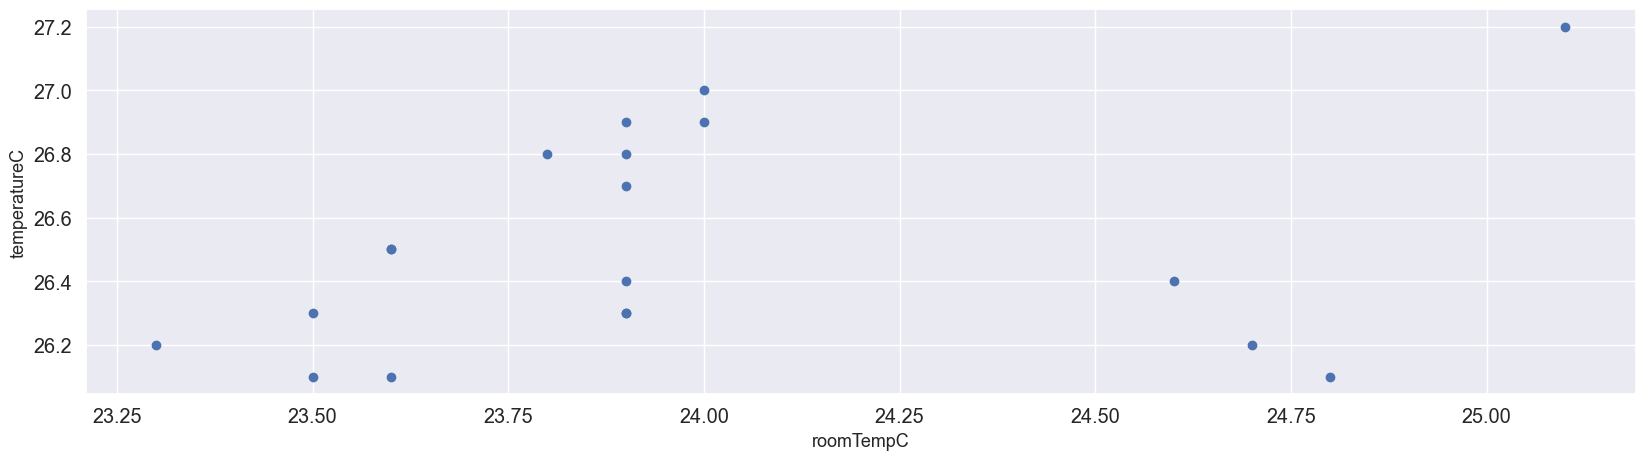

In [1174]:
below_3deg = AOP_data[(AOP_data['temperatureC']) - (AOP_data['roomTempC']) <= 3]
print(below_3deg.shape)

fig, axs = plt.subplots(figsize=(20, 5))
axs.scatter(x=below_3deg['roomTempC'], y=below_3deg['temperatureC'])
plt.xlabel('roomTempC', fontsize=13)
plt.ylabel('temperatureC', fontsize=13)

plt.show()

##### roomTempC가 26도를 넘는 case 확인

(0, 23)


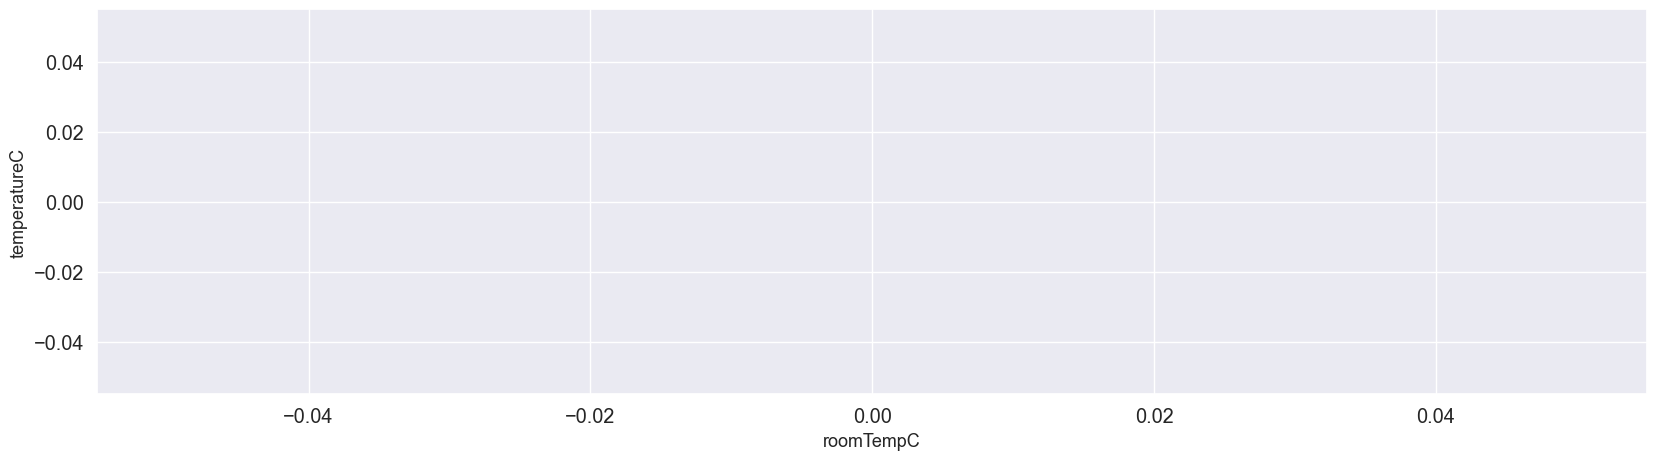

In [1175]:
over_roomT = AOP_data[AOP_data['roomTempC'] > 26]
print(over_roomT.shape)

fig, axs = plt.subplots(figsize=(20, 5))
axs.scatter(x=over_roomT['roomTempC'], y=over_roomT['temperatureC'])
plt.xlabel('roomTempC', fontsize=13)
plt.ylabel('temperatureC', fontsize=13)

plt.show()

##### Drop unnecessary data
- temperatureRise가 2도 이하일 경우, Drop

In [1176]:
print('Before drop unnecessary data:', AOP_data.shape)

## <Drop unnecessary data>
## pulseRepetRate가 18000(CW) 이상이거나 또는 온도가 26도 미만일 경우는 Drop.
# - As below, Drop condition output test code.
#     - AOP_data[(AOP_data['roomTempC']>26)].to_csv('drop_data.csv')
AOP_data = AOP_data.drop(AOP_data[(AOP_data['roomTempC']>26) | ((AOP_data['temperatureC']) - (AOP_data['roomTempC']) <= 2)].index)
print('After drop unnecessary data:', AOP_data.shape)

Before drop unnecessary data: (5450, 23)
After drop unnecessary data: (5441, 23)


##### target data check

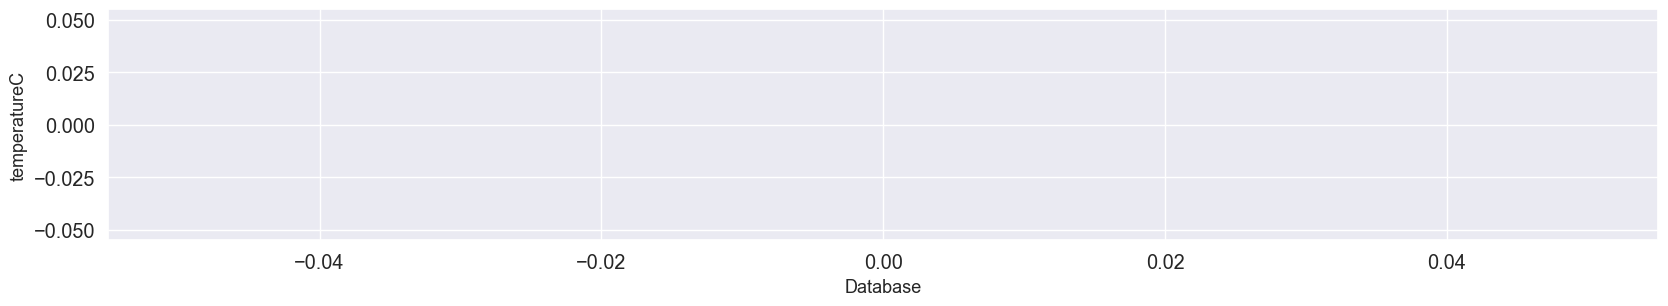

In [1177]:
over_roomT = AOP_data[AOP_data['roomTempC'] > 26]

fig, axs = plt.subplots(figsize=(20, 3))
axs.scatter(x=over_roomT['Database'], y=over_roomT['temperatureC'])
plt.xlabel('Database', fontsize=13)
plt.ylabel('temperatureC', fontsize=13)

plt.show()

(0, 23)


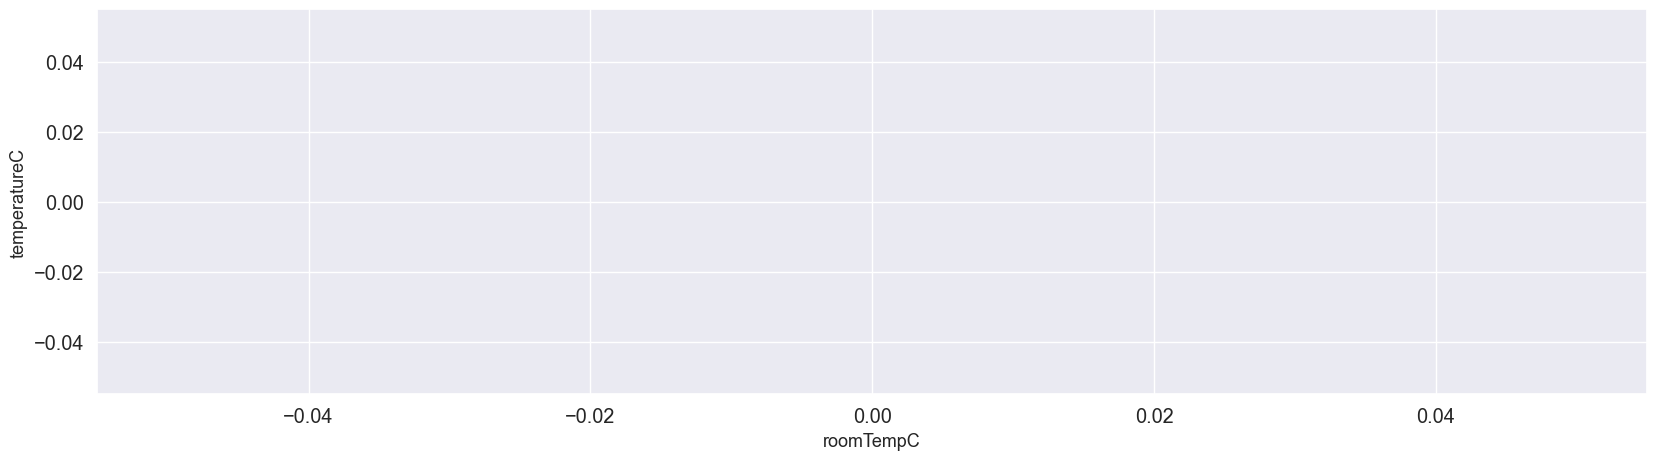

In [1178]:
below_2deg = AOP_data[(AOP_data['temperatureC']) - (AOP_data['roomTempC']) <= 2]
print(below_2deg.shape)

fig, axs = plt.subplots(figsize=(20, 5))
axs.scatter(x=below_2deg['roomTempC'], y=below_2deg['temperatureC'])
plt.xlabel('roomTempC', fontsize=13)
plt.ylabel('temperatureC', fontsize=13)

plt.show()

##### another outlier check

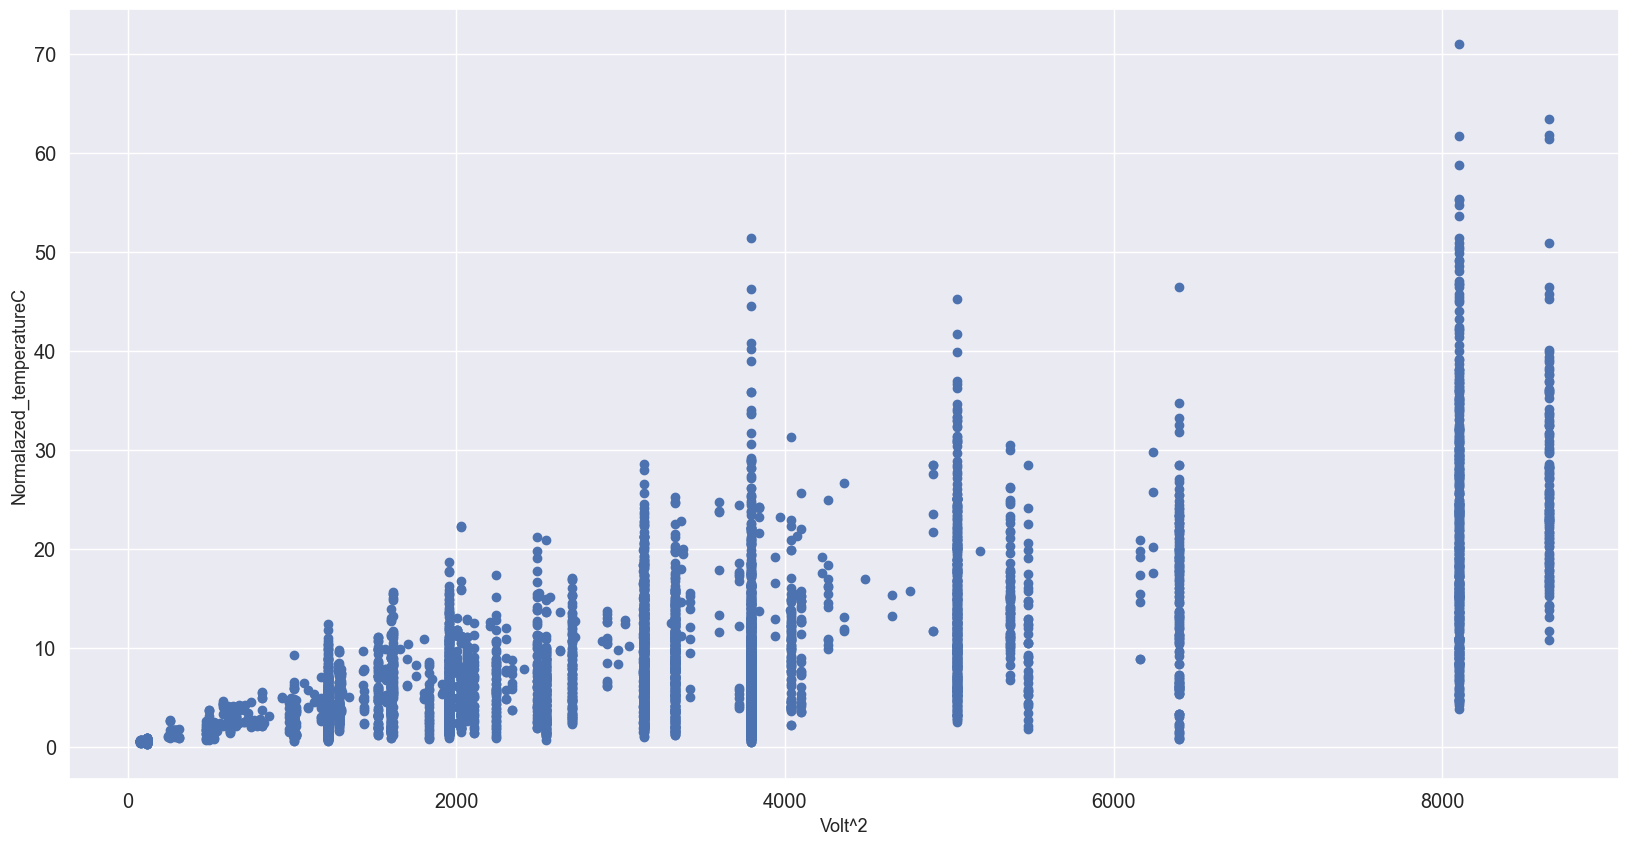

In [1179]:
fig, axs = plt.subplots(figsize=(20, 10))
axs.scatter(x = AOP_data['volt2'], 
            y = (AOP_data['temperatureC']) / (AOP_data['numTxCycles'] * (AOP_data['pulseRepetRate']/1000)))
plt.xlabel('Volt^2', fontsize=13)
plt.ylabel('Normalazed_temperatureC', fontsize=13)

plt.show()

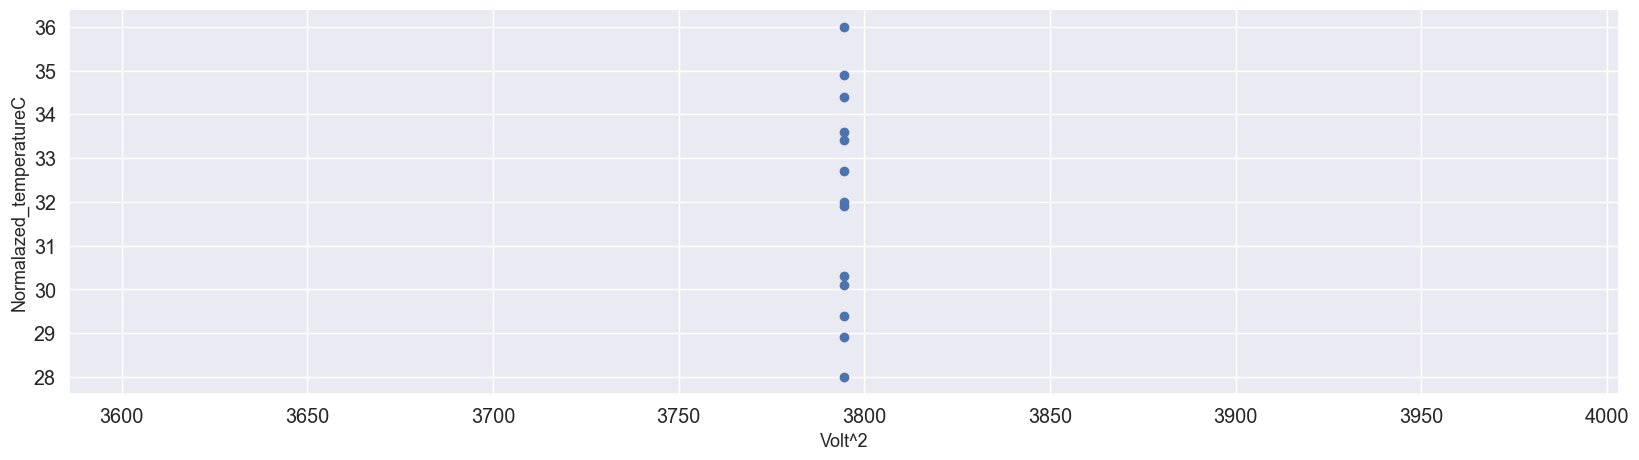

In [1180]:
outlier2 = AOP_data[(AOP_data['volt2'] < 4000) & ((AOP_data['temperatureC']) / (AOP_data['numTxCycles'] * (AOP_data['pulseRepetRate']/1000)) > 30)]

fig, axs = plt.subplots(figsize=(20, 5))
axs.scatter(x = outlier2['volt2'], y = outlier2['temperatureC'])
plt.xlabel('Volt^2', fontsize=13)
plt.ylabel('Normalazed_temperatureC', fontsize=13)

plt.show()

In [1181]:
outlier2.head(15)

Database  temperatureId   probeId  tempSSId  measSetNum  roomTempC  \
81    Griffin_r01            692  11284923       784           3  23.900000   
87    Griffin_r01            700  11284923       784           3  23.900000   
89    Griffin_r01            703  11284923       784           3  23.900000   
93    Griffin_r01            709  11284923       784           3  23.799999   
95    Griffin_r01            712  11284923       784           3  23.799999   
97    Griffin_r01            714  11284923       784           3  23.799999   
98    Griffin_r01            716  11284923       784           3  23.799999   
1383  Griffin_r01           5279  11370949      5147           3  21.500000   
1384  Griffin_r01           5280  11370949      5147           3  21.299999   
1388  Griffin_r01           5284  11370949      5147           3  21.400000   
1389  Griffin_r01           5285  11370949      5147           3  21.200001   
1390  Griffin_r01           5286  11370949      5147           3  21.200001   
1391  Griffin_r01           5287  11370949      5147           3  21.299999   

      pulseVoltage  temperatureC  numTxCycles  numTxElements  ...  \
81       61.599998     33.599998          1.5             64  ...   
87       61.599998     33.400002          1.5             96  ...   
89       61.599998     34.900002          1.5             96  ...   
93       61.599998     32.000000          1.5            128  ...   
95       61.599998     32.700001          1.5            128  ...   
97       61.599998     34.400002          1.5            128  ...   
98       61.599998     36.000000          1.5            128  ...   
1383     61.599998     29.400000          2.0             48  ...   
1384     61.599998     30.299999          2.0             48  ...   
1388     61.599998     28.000000          2.0             64  ...   
1389     61.599998     28.900000          2.0             64  ...   
1390     61.599998     30.100000          2.0             64  ...   
1391     61.599998     31.900000          2.0             64  ...   

      txpgWaveformStyle  pulseRepetRate  scanRange  probePitchCm  \
81                    2      664.190002   0.132179        0.0212   
87                    2      546.570007   0.132179        0.0212   
89                    2      649.349976   0.731390        0.0212   
93                    2      415.420013   0.132179        0.0212   
95                    2      470.989990   0.731390        0.0212   
97                    2      588.510010   1.471590        0.0212   
98                    2      706.210022   2.070800        0.0212   
1383                  2      437.059998   0.000739        0.0148   
1384                  2      495.250000   0.000895        0.0148   
1388                  2      314.700012   0.000739        0.0148   
1389                  2      359.709991   0.000895        0.0148   
1390                  2      419.600006   0.004612        0.0148   
1391                  2      503.420013   0.009596        0.0148   

      probeRadiusCm  probeElevAperCm0  probeNumElements  probeElevFocusRangCm  \
81             1.48               0.5             128.0                   1.9   
87             1.48               0.5             128.0                   1.9   
89             1.48               0.5             128.0                   1.9   
93             1.48               0.5             128.0                   1.9   
95             1.48               0.5             128.0                   1.9   
97             1.48               0.5             128.0                   1.9   
98             1.48               0.5             128.0                   1.9   
1383           0.00               0.6              64.0                   5.5   
1384           0.00               0.6              64.0                   5.5   
1388           0.00               0.6              64.0                   5.5   
1389           0.00               0.6              64.0                   5.5   
1390      

##### scanRange에 의한 차이로 보임

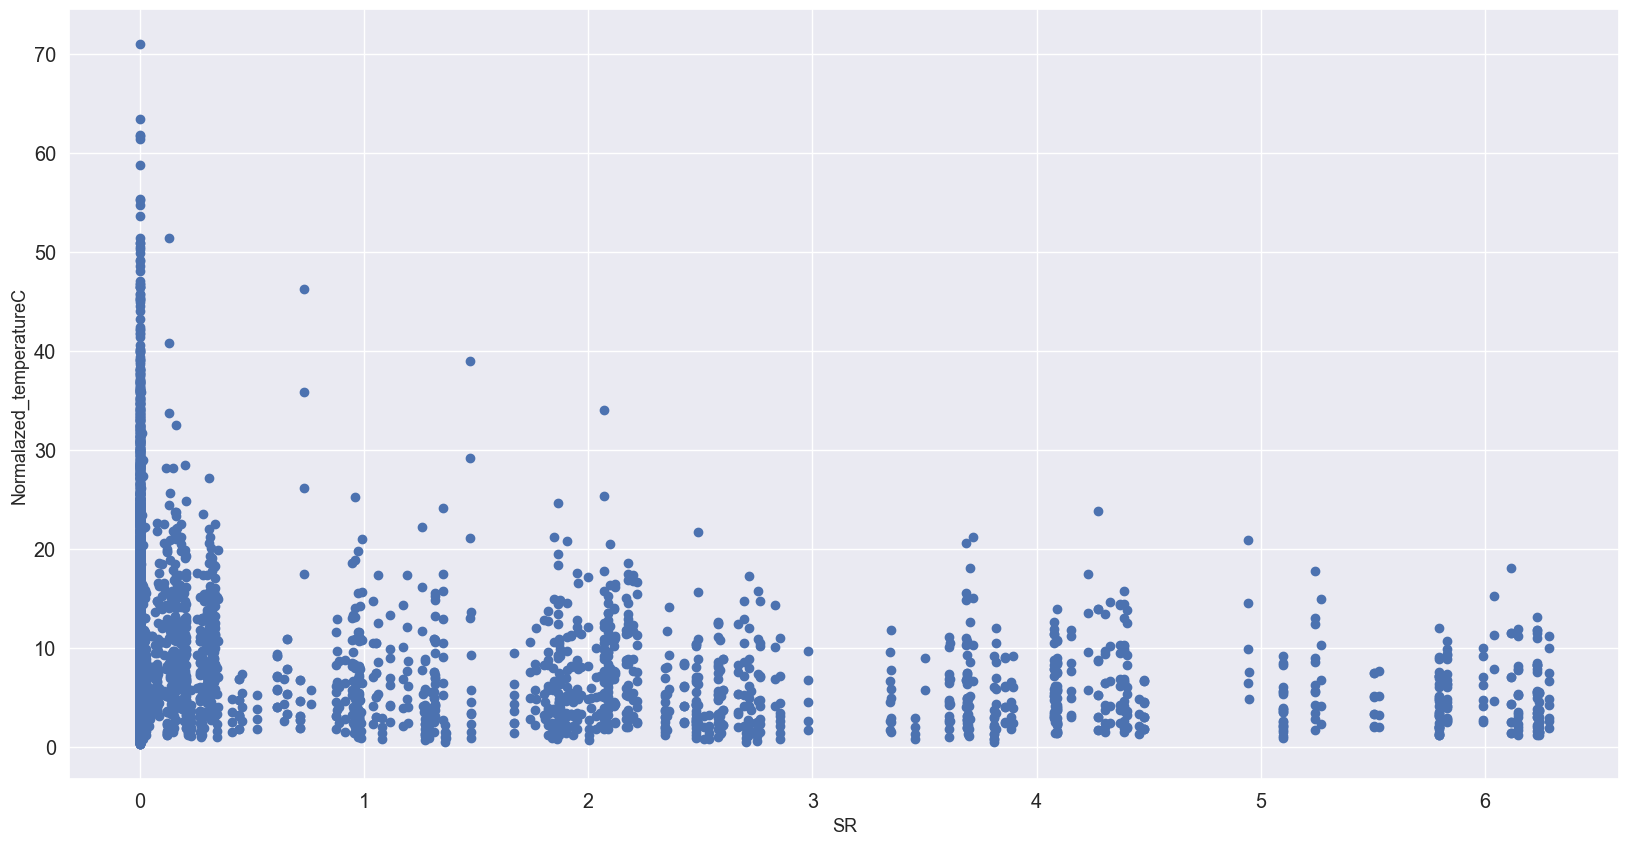

In [1182]:
fig, axs = plt.subplots(figsize=(20, 10))
axs.scatter(x = AOP_data['scanRange'], y = (AOP_data['temperatureC']) / (AOP_data['numTxCycles'] * (AOP_data['pulseRepetRate']/1000)))
plt.xlabel('SR', fontsize=13)
plt.ylabel('Normalazed_temperatureC', fontsize=13)

plt.show()

---
>#### 2) Relationship with categorical features
- voltage_norm vs. WF

In [1183]:
AOP_data['normal_Temp'] = (AOP_data['temperatureC']) / (AOP_data['numTxCycles'] * (AOP_data['pulseRepetRate']/1000))
AOP_data['volt_norm'] = AOP_data['normal_Temp'] / (AOP_data['pulseVoltage'] * AOP_data['pulseVoltage'])


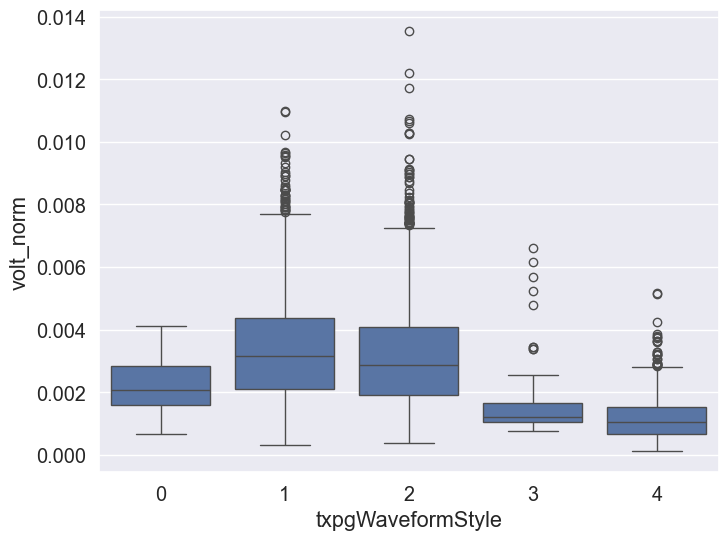

In [1184]:
# ## box plot normal_temp vs. txpgWaveformStyle
var = 'txpgWaveformStyle'
target = 'volt_norm'
selected_params = [var, target]
selected_df = AOP_data[selected_params]

# Seaborn을 사용하여 박스플롯 그리기
fig, axs = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y=target, data=selected_df)
# fig.axis(ymin=0, ymax=0.01)

- voltage vs. ProbeDescription

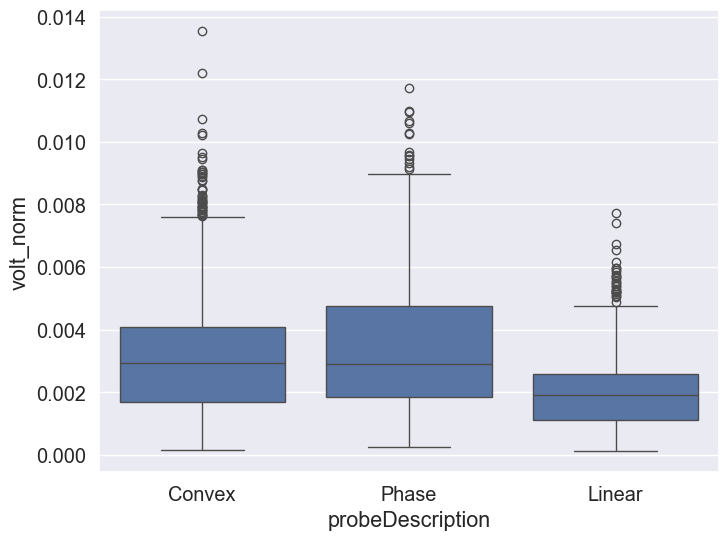

In [1185]:
## box plot normal_temp vs. probeDescription
var = 'probeDescription'
target = 'volt_norm'

selected_params = [var, target]
selected_df = AOP_data[selected_params]

# Seaborn을 사용하여 박스플롯 그리기
fig, axs = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y=target, data=selected_df)
# fig.axis(ymin=0, ymax=0.01)

- voltage vs. isTxAperModulationEn

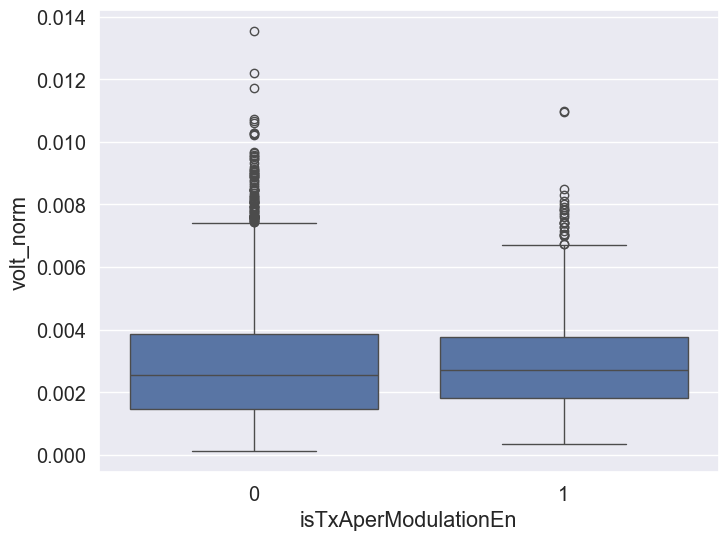

In [1186]:
## box plot normal_temp vs. probeDescription
var = 'isTxAperModulationEn'
target = 'volt_norm'

selected_params = [var, target]
selected_df = AOP_data[selected_params]

# Seaborn을 사용하여 박스플롯 그리기
fig, axs = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y=target, data=selected_df)
# fig.axis(ymin=0, ymax=0.01)

---
>### 쓸모없는 데이터 삭제 후, 확률 및 분포 확인하기
- temperatureC 선택하여 데이터 분석하기

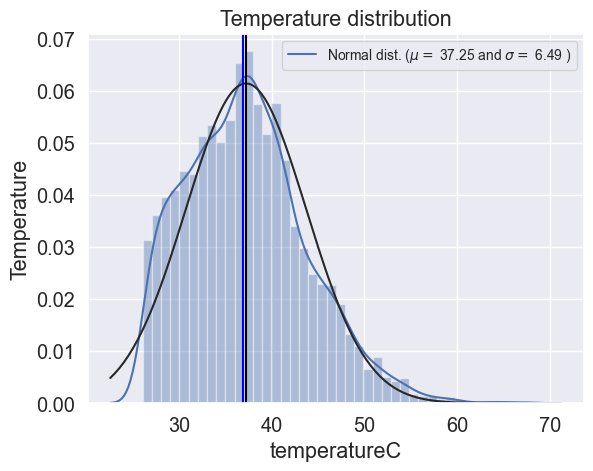

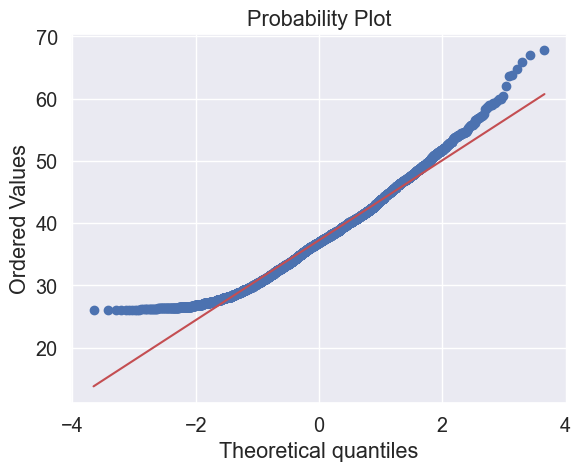

Skewness & Temp: 0.548309
Kurtosis & Temp: 0.240330


In [1187]:
Temperature = (AOP_data['temperatureC'])

sns.distplot(Temperature , fit=norm);

## Get the fitted parameters used by the function
(mu, sigma) = norm.fit(Temperature)

## Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best', fontsize=10)
plt.ylabel('Temperature')
plt.title('Temperature distribution')

## Temperature mean and median value display
plt.axvline(Temperature.mean(), color='black')
plt.axvline(Temperature.median(), color='blue')

## Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(Temperature, plot=plt)
plt.show()

#skewness and kurtosis
print("Skewness & Temp: %f" % Temperature.skew())
print("Kurtosis & Temp: %f" % Temperature.kurt())

In [1188]:
print(AOP_data.columns)
print(AOP_data.shape)

Index(['Database', 'temperatureId', 'probeId', 'tempSSId', 'measSetNum',
       'roomTempC', 'pulseVoltage', 'temperatureC', 'numTxCycles',
       'numTxElements', 'txFrequencyHz', 'elevAperIndex',
       'isTxAperModulationEn', 'txpgWaveformStyle', 'pulseRepetRate',
       'scanRange', 'probePitchCm', 'probeRadiusCm', 'probeElevAperCm0',
       'probeNumElements', 'probeElevFocusRangCm', 'probeDescription', 'volt2',
       'normal_Temp', 'volt_norm'],
      dtype='object')
(5441, 25)


---
>#### 3) categorical vs. numerical feature
- one hot encoder 적용을 위한 데이터 구분

In [1189]:
nameNumerical = ['roomTempC', 'pulseVoltage', 'numTxCycles', 'numTxElements', 'txFrequencyHz',
                 'elevAperIndex', 'isTxAperModulationEn', 'pulseRepetRate', 'scanRange',
                 'probePitchCm', 'probeRadiusCm', 'probeElevAperCm0', 'probeNumElements', 'probeElevFocusRangCm', 'volt2', 'temperatureC',
                 'normal_Temp', 'volt_norm']

# 'txpgWaveformStyle'를 문자열로 변환
AOP_data['txpgWaveformStyle'] = AOP_data['txpgWaveformStyle'].astype(str)
AOP_data['probeId'] = AOP_data['probeId'].astype(str)


nameCategorical = ['probeDescription', 'txpgWaveformStyle', 'probeId']

# 범주형 데이터에 대해 one-hot encoding 적용
encoded_data = pd.get_dummies(AOP_data[nameCategorical])

# 범주형이 아닌 데이터와 one-hot encoded 데이터를 합침
AOP_data = pd.concat([AOP_data[nameNumerical], encoded_data], axis=1)

AOP_data.head()

roomTempC  pulseVoltage  numTxCycles  numTxElements  txFrequencyHz  \
0  22.299999     34.899807          2.0            128      2500000.0   
1  22.400000     44.226025          2.0            128      2500000.0   
2  22.799999     56.044472          2.0            128      2500000.0   
3  23.000000     71.021141          2.0            128      2500000.0   
4  23.100000     90.000000          2.0            128      2500000.0   

   elevAperIndex  isTxAperModulationEn  pulseRepetRate  scanRange  \
0              0                     1     2687.000000        0.0   
1              0                     1     1810.520020        0.0   
2              0                     1     1219.949951        0.0   
3              0                     1      822.010010        0.0   
4              0                     1      553.880005        0.0   

   probePitchCm  ...  probeId_151  probeId_154  probeId_157  probeId_162  \
0       0.04765  ...        False        False        False        False   
1       0.04765  ...        False        False        False        False   
2       0.04765  ...        False        False        False        False   
3       0.04765  ...        False        False        False        False   
4       0.04765  ...        False        False        False        False   

   probeId_167  probeId_187  probeId_231  probeId_244  probeId_554  \
0        False        False        False        False        False   
1        False        False        False        False        False   
2        False        False        False        False        False   
3        False        False        False        False        False   
4        False        False        False        False        False   

   probeId_656  
0        False  
1        False  
2        False  
3        False  
4        False  

[5 rows x 74 columns]

In [1190]:
# # one-hot 인코딩 수행
# encoded = pd.get_dummies(AOP_data['probeId'])

# # 인코딩 결과는 원본 데이터프레임에 다시 합쳐줍니다.
# AOP_data = pd.concat([AOP_data, encoded], axis=1)

# # 원본 범주형 데이터 열은 더 이상 필요 없으므로 삭제합니다.
# AOP_data.drop('probeId', axis=1, inplace=True)

In [1191]:
AOP_data.shape

(5441, 74)

In [1192]:
AOP_data.head()

roomTempC  pulseVoltage  numTxCycles  numTxElements  txFrequencyHz  \
0  22.299999     34.899807          2.0            128      2500000.0   
1  22.400000     44.226025          2.0            128      2500000.0   
2  22.799999     56.044472          2.0            128      2500000.0   
3  23.000000     71.021141          2.0            128      2500000.0   
4  23.100000     90.000000          2.0            128      2500000.0   

   elevAperIndex  isTxAperModulationEn  pulseRepetRate  scanRange  \
0              0                     1     2687.000000        0.0   
1              0                     1     1810.520020        0.0   
2              0                     1     1219.949951        0.0   
3              0                     1      822.010010        0.0   
4              0                     1      553.880005        0.0   

   probePitchCm  ...  probeId_151  probeId_154  probeId_157  probeId_162  \
0       0.04765  ...        False        False        False        False   
1       0.04765  ...        False        False        False        False   
2       0.04765  ...        False        False        False        False   
3       0.04765  ...        False        False        False        False   
4       0.04765  ...        False        False        False        False   

   probeId_167  probeId_187  probeId_231  probeId_244  probeId_554  \
0        False        False        False        False        False   
1        False        False        False        False        False   
2        False        False        False        False        False   
3        False        False        False        False        False   
4        False        False        False        False        False   

   probeId_656  
0        False  
1        False  
2        False  
3        False  
4        False  

[5 rows x 74 columns]

In [1193]:
AOP_data.to_csv('final_AOP_data_check.csv')

In [1194]:
AOP_data.columns

Index(['roomTempC', 'pulseVoltage', 'numTxCycles', 'numTxElements',
       'txFrequencyHz', 'elevAperIndex', 'isTxAperModulationEn',
       'pulseRepetRate', 'scanRange', 'probePitchCm', 'probeRadiusCm',
       'probeElevAperCm0', 'probeNumElements', 'probeElevFocusRangCm', 'volt2',
       'temperatureC', 'normal_Temp', 'volt_norm', 'probeDescription_Convex',
       'probeDescription_Linear', 'probeDescription_Phase',
       'txpgWaveformStyle_0', 'txpgWaveformStyle_1', 'txpgWaveformStyle_2',
       'txpgWaveformStyle_3', 'txpgWaveformStyle_4', 'probeId_10136142',
       'probeId_10136143', 'probeId_11014154', 'probeId_11014543',
       'probeId_11014552', 'probeId_112', 'probeId_11268276',
       'probeId_11268277', 'probeId_11268278', 'probeId_11268279',
       'probeId_11268679', 'probeId_11284920', 'probeId_11284921',
       'probeId_11284922', 'probeId_11284923', 'probeId_11284924',
       'probeId_11319682', 'probeId_11319697', 'probeId_11361589',
       'probeId_11370778', 'prob

---
>### Data Correlation
- Correlation map to see how features are correlated with TemperatureRise

<Axes: title={'center': 'Temperature Correlation of Features'}>

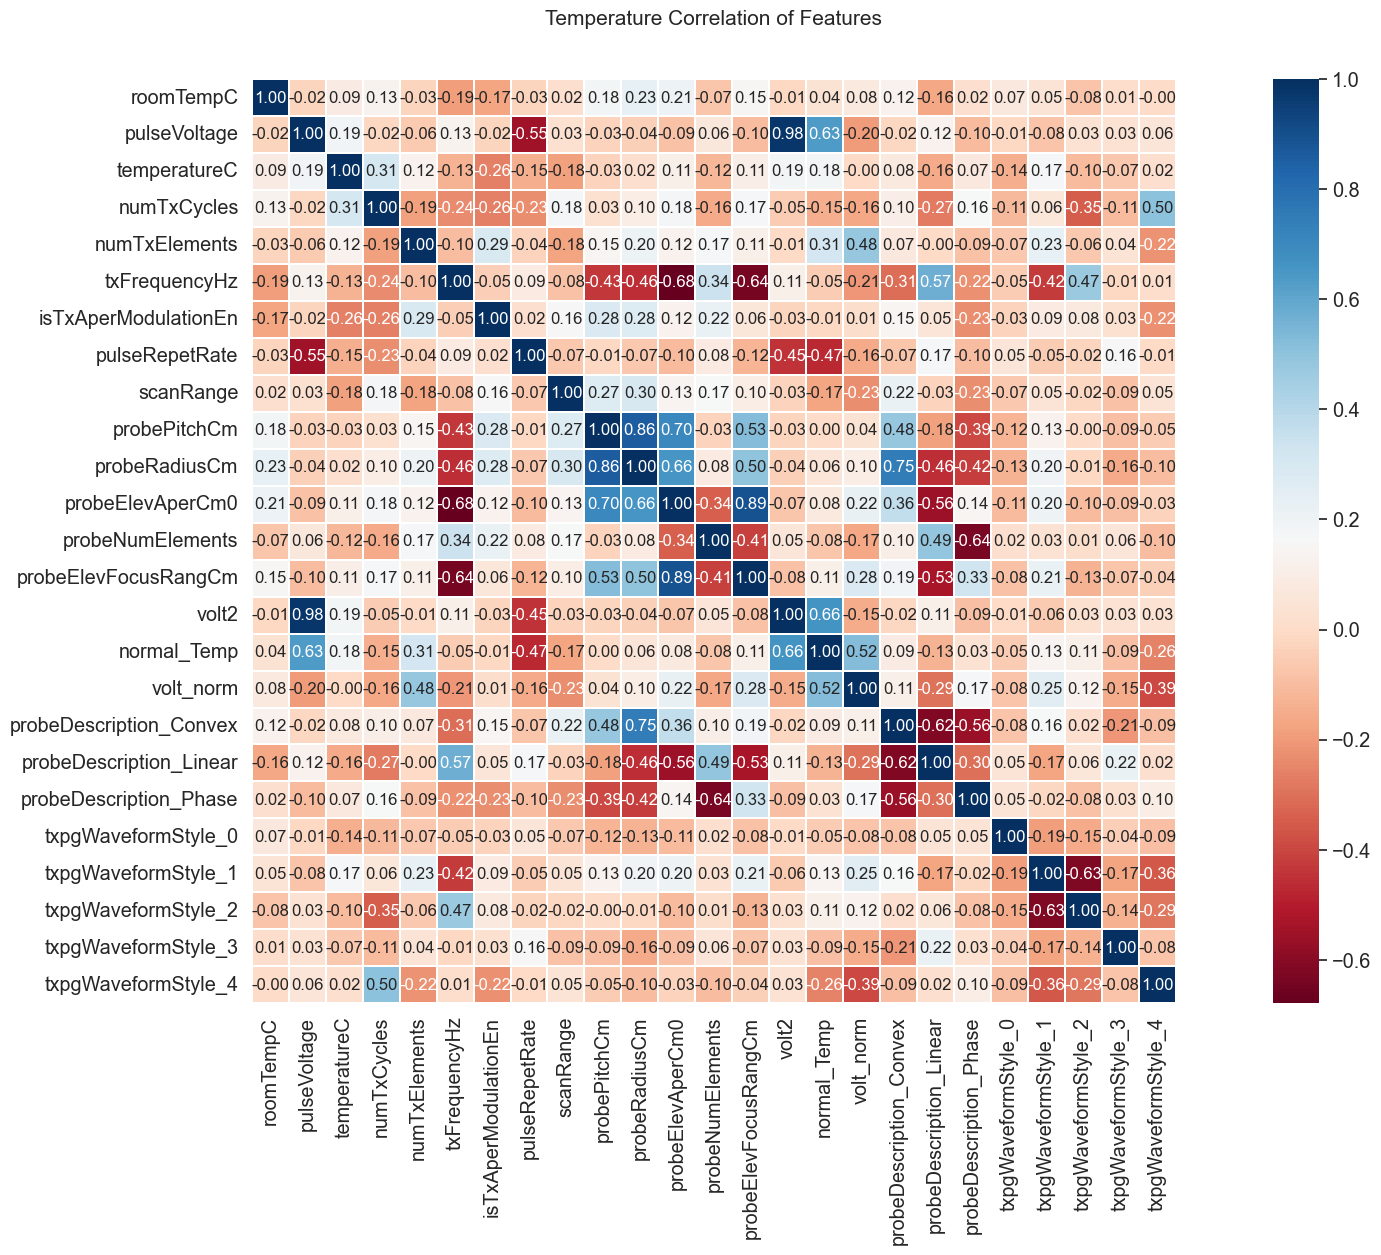

In [1195]:
heatmap_data = AOP_data[['roomTempC', 'pulseVoltage', 'temperatureC', 'numTxCycles',
       'numTxElements', 'txFrequencyHz', 'isTxAperModulationEn', 'pulseRepetRate',
       'scanRange', 'probePitchCm', 'probeRadiusCm', 'probeElevAperCm0',
       'probeNumElements', 'probeElevFocusRangCm', 'volt2',
       'normal_Temp', 'volt_norm', 'probeDescription_Convex',
       'probeDescription_Linear', 'probeDescription_Phase',
       'txpgWaveformStyle_0', 'txpgWaveformStyle_1', 'txpgWaveformStyle_2',
       'txpgWaveformStyle_3', 'txpgWaveformStyle_4', 
       ]] 

colormap = plt.cm.RdBu
plt.figure(figsize=(25, 12))
plt.title('Temperature Correlation of Features', y=1.05, size=15)

sns.heatmap(heatmap_data.astype(float).corr(), linewidths=0.1, vmax=1.0, fmt='.2f',
           square=True, cmap=colormap, linecolor='white', annot=True, annot_kws={"size": 12})

---
>### 데이터선택 및 데이터 구분하기

In [1196]:
log_temp = np.log1p(Temperature)
AOP_data = AOP_data.assign(log_temp=log_temp)

In [1197]:
print(AOP_data.columns)
print(AOP_data.shape)

Index(['roomTempC', 'pulseVoltage', 'numTxCycles', 'numTxElements',
       'txFrequencyHz', 'elevAperIndex', 'isTxAperModulationEn',
       'pulseRepetRate', 'scanRange', 'probePitchCm', 'probeRadiusCm',
       'probeElevAperCm0', 'probeNumElements', 'probeElevFocusRangCm', 'volt2',
       'temperatureC', 'normal_Temp', 'volt_norm', 'probeDescription_Convex',
       'probeDescription_Linear', 'probeDescription_Phase',
       'txpgWaveformStyle_0', 'txpgWaveformStyle_1', 'txpgWaveformStyle_2',
       'txpgWaveformStyle_3', 'txpgWaveformStyle_4', 'probeId_10136142',
       'probeId_10136143', 'probeId_11014154', 'probeId_11014543',
       'probeId_11014552', 'probeId_112', 'probeId_11268276',
       'probeId_11268277', 'probeId_11268278', 'probeId_11268279',
       'probeId_11268679', 'probeId_11284920', 'probeId_11284921',
       'probeId_11284922', 'probeId_11284923', 'probeId_11284924',
       'probeId_11319682', 'probeId_11319697', 'probeId_11361589',
       'probeId_11370778', 'prob

>#### 필요없는 데이터 삭제

In [1198]:
## 데이터 구분 / temperatureC를 제일 뒤로 이동.
cols = ['roomTempC', 'pulseVoltage', 'numTxCycles', 'numTxElements',
       'txFrequencyHz', 'elevAperIndex', 'isTxAperModulationEn',
       'pulseRepetRate', 'scanRange', 'probePitchCm', 'probeRadiusCm',
       'probeElevAperCm0', 'probeNumElements', 'probeElevFocusRangCm', 'volt2',
       'probeDescription_Convex',
       'probeDescription_Linear', 'probeDescription_Phase',
       'txpgWaveformStyle_0', 'txpgWaveformStyle_1', 'txpgWaveformStyle_2',
       'txpgWaveformStyle_3', 'txpgWaveformStyle_4', 'probeId_10136142',
       'probeId_10136143', 'probeId_11014154', 'probeId_11014543',
       'probeId_11014552', 'probeId_112', 'probeId_11268276',
       'probeId_11268277', 'probeId_11268278', 'probeId_11268279',
       'probeId_11268679', 'probeId_11284920', 'probeId_11284921',
       'probeId_11284922', 'probeId_11284923', 'probeId_11284924',
       'probeId_11319682', 'probeId_11319697', 'probeId_11361589',
       'probeId_11370778', 'probeId_11370949', 'probeId_11503481',
       'probeId_11503732', 'probeId_11575443', 'probeId_11575444',
       'probeId_11575446', 'probeId_11711157', 'probeId_11712408',
       'probeId_128', 'probeId_140', 'probeId_142', 'probeId_143',
       'probeId_146', 'probeId_147', 'probeId_148', 'probeId_149',
       'probeId_1490', 'probeId_150', 'probeId_151', 'probeId_154',
       'probeId_157', 'probeId_162', 'probeId_167', 'probeId_187',
       'probeId_231', 'probeId_244', 'probeId_554', 'probeId_656',
       'log_temp',
       'temperatureC', 'normal_Temp', 'volt_norm']

AOP_data = AOP_data[cols]

AOP_data.head()

roomTempC  pulseVoltage  numTxCycles  numTxElements  txFrequencyHz  \
0  22.299999     34.899807          2.0            128      2500000.0   
1  22.400000     44.226025          2.0            128      2500000.0   
2  22.799999     56.044472          2.0            128      2500000.0   
3  23.000000     71.021141          2.0            128      2500000.0   
4  23.100000     90.000000          2.0            128      2500000.0   

   elevAperIndex  isTxAperModulationEn  pulseRepetRate  scanRange  \
0              0                     1     2687.000000        0.0   
1              0                     1     1810.520020        0.0   
2              0                     1     1219.949951        0.0   
3              0                     1      822.010010        0.0   
4              0                     1      553.880005        0.0   

   probePitchCm  ...  probeId_167  probeId_187  probeId_231  probeId_244  \
0       0.04765  ...        False        False        False        False   
1       0.04765  ...        False        False        False        False   
2       0.04765  ...        False        False        False        False   
3       0.04765  ...        False        False        False        False   
4       0.04765  ...        False        False        False        False   

   probeId_554  probeId_656  log_temp  temperatureC  normal_Temp  volt_norm  
0        False        False  3.555348     34.000000     6.326758   0.005194  
1        False        False  3.586293     35.099998     9.693347   0.004956  
2        False        False  3.618993     36.299999    14.877659   0.004737  
3        False        False  3.653252     37.599998    22.870767   0.004534  
4        False        False  3.683867     38.799999    35.025636   0.004324  

[5 rows x 75 columns]

In [1199]:
nameColumns = AOP_data.columns[0:71]
print(nameColumns)

Index(['roomTempC', 'pulseVoltage', 'numTxCycles', 'numTxElements',
       'txFrequencyHz', 'elevAperIndex', 'isTxAperModulationEn',
       'pulseRepetRate', 'scanRange', 'probePitchCm', 'probeRadiusCm',
       'probeElevAperCm0', 'probeNumElements', 'probeElevFocusRangCm', 'volt2',
       'probeDescription_Convex', 'probeDescription_Linear',
       'probeDescription_Phase', 'txpgWaveformStyle_0', 'txpgWaveformStyle_1',
       'txpgWaveformStyle_2', 'txpgWaveformStyle_3', 'txpgWaveformStyle_4',
       'probeId_10136142', 'probeId_10136143', 'probeId_11014154',
       'probeId_11014543', 'probeId_11014552', 'probeId_112',
       'probeId_11268276', 'probeId_11268277', 'probeId_11268278',
       'probeId_11268279', 'probeId_11268679', 'probeId_11284920',
       'probeId_11284921', 'probeId_11284922', 'probeId_11284923',
       'probeId_11284924', 'probeId_11319682', 'probeId_11319697',
       'probeId_11361589', 'probeId_11370778', 'probeId_11370949',
       'probeId_11503481', 'probeId_

In [1200]:
data = AOP_data.iloc[:, 0:71].to_numpy()
target = AOP_data['temperatureC'].to_numpy()

- data / target 데이터 --> train / test 구분하기

In [1201]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_absolute_error, mean_squared_error


train_input, test_input, train_target, test_target = train_test_split(data, target, test_size=0.2, shuffle=True)

>### 머신러닝 모델 사용하기
#### 1) Linear-Regression 모델 사용하기

In [1202]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(train_input)
train_scaled = ss.transform(train_input)
test_scaled = ss.transform(test_input)


from sklearn.linear_model import LinearRegression
model_lr = LinearRegression()


## Cross validate 진행하기
scores = cross_validate(model_lr, train_scaled, train_target, scoring='neg_root_mean_squared_error', 
                        cv=5,return_train_score=True, n_jobs=-1)
print()
print(scores)


train_rmse = (-1 * scores['train_score']).mean()
train_val_rmse = (-1 * scores['test_score']).mean()
print(f'Train RMSE: {train_rmse:.3f}')
print(f'train_val RMSE: {train_val_rmse:.3f}')

## 훈련하기 / test predict
model_lr.fit(train_scaled, train_target)
test_prediction = model_lr.predict(test_scaled)
test_rmse = mean_squared_error(test_target, test_prediction)
print(f'Test RMSE: {test_rmse:.3f}')


mae = mean_absolute_error(test_target, test_prediction)
print(f'|(타깃 - 예측값)|: {mae:.3f}')


{'fit_time': array([0.01407599, 0.01214671, 0.0150075 , 0.01525998, 0.01451516]), 'score_time': array([0.00140905, 0.00099921, 0.00099134, 0.00153756, 0.        ]), 'test_score': array([-4.28310774, -4.44420161, -4.61907641, -4.73187081, -4.47609202]), 'train_score': array([-4.50699055, -4.4401362 , -4.40177223, -4.38880602, -4.45678767])}
Train RMSE: 4.439
train_val RMSE: 4.511
Test RMSE: 21.200
|(타깃 - 예측값)|: 3.475


- R2 확인 및 데이터 추출(LinearRegression)

In [1203]:
scores = cross_validate(model_lr, train_scaled, train_target, return_train_score=True, n_jobs=-1) 
print() 
print(scores) 

print('Train R^2:', np.round(np.mean(scores['train_score']), 3)) 
print('Train_validation R^2:', np.round(np.mean(scores['test_score']), 3)) 


model_lr.fit(train_scaled, train_target) 
print('Test R^2:', np.round(model_lr.score(test_scaled, test_target), 3))


prediction = np.round(model_lr.predict(test_scaled), 2) 
mae = mean_absolute_error(test_target, prediction) 
print('|(타깃 - 예측값)|:', mae) 
Diff = np.round(prediction - test_target, 2) 


inverseTest = ss.inverse_transform(test_scaled)


pdTestData = pd.DataFrame(inverseTest, columns=nameColumns)
pdTestTarget = pd.DataFrame(test_target,  columns=['TemperatureC'])
pdPredData = pd.DataFrame(prediction, columns=['prediction'])


test_result = pd.concat([pdTestData, pdTestTarget, pdPredData], axis=1)
test_result.to_csv("model_lr_test_result.csv")


{'fit_time': array([0.00895166, 0.02726102, 0.01538086, 0.02646685, 0.02059865]), 'score_time': array([0.00105929, 0.00149751, 0.00100088, 0.00167847, 0.00119519]), 'test_score': array([0.56682732, 0.52845142, 0.50629097, 0.4748553 , 0.49587492]), 'train_score': array([0.5154152 , 0.53112443, 0.53535764, 0.53931216, 0.53353791])}
Train R^2: 0.531
Train_validation R^2: 0.514
Test R^2: 0.504
|(타깃 - 예측값)|: 3.4751404525995033


---
#### 2) PolynomialFeatures 사용하여 linearRegression 활용하기.
- y = ax + b

In [1204]:
## a(기울기)와 b(offset) 출력해보기
print(train_scaled.shape)
print(model_lr.coef_, model_lr.intercept_)

(4352, 71)
[ 9.76922208e-01  8.71390036e+00  3.39370204e+00  2.02694667e+00
 -1.72133841e+00 -4.63798466e+13 -1.13341881e+00  2.05539472e+00
 -1.43944719e+00  5.55148468e+01 -5.91378183e+12 -9.11023455e+00
 -3.74413207e+13  4.94126477e+00 -6.45212195e+00 -4.79600986e+13
  2.49118123e+13  1.75221161e+13 -8.93168649e+12 -2.09832145e+13
 -2.00583097e+13 -7.89822575e+12 -1.49225741e+13 -1.37512430e+13
 -2.37216491e+13 -1.61267227e+13 -1.39048073e+13 -1.58538975e+12
  1.36055355e+13  1.41682229e+13  2.21533047e+13  2.29064350e+13
 -1.60629549e+12  8.78078727e+12  1.74735520e+13  1.17819495e+13
  9.09332531e+12  2.32709956e+13 -1.84631600e+12 -1.45854327e+13
 -5.57810670e+12 -1.63711726e+12  3.24691979e+12 -1.67924612e+13
  1.99570971e+13  6.70415866e+12  8.76931866e+12  1.20386397e+13
  1.10539384e+13  2.01013103e+13  6.51800231e+12 -8.52589101e+12
  1.85276895e+13 -9.87784627e+12 -2.41808354e+12  9.29378033e+12
  1.35909213e+13 -1.11068719e+12  8.42378620e+12  1.06652559e+13
 -1.07468074e+

- 특성을 만들거나 전처리하기 위한 다양한 클래스 사용: PolynomialFeatures

In [1205]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures()
poly.fit([[2, 3]])

print(poly.transform([[2, 3]]))

## 무게 = a x 길이 + b x 높이 + c x 두께 + d x 1
## (길이, 높이, 두께, 1)    

[[1. 2. 3. 4. 6. 9.]]


In [1206]:
## 절편을 제거하여 출력
poly = PolynomialFeatures(include_bias=False)
poly.fit([[2, 3]])

print(poly.transform([[2, 3]]))

[[2. 3. 4. 6. 9.]]


In [1207]:
## train_input vs. train_poly 비교
print(train_input.shape)

poly = PolynomialFeatures(degree=2, include_bias=False)
poly.fit(train_input)
train_poly = poly.transform(train_input)
test_poly = poly.transform(test_input)

print(train_poly.shape)

(4352, 71)
(4352, 2627)


-  몇 개의 feature가 생성이 되었는지 확인

In [1208]:
poly.get_feature_names_out()

array(['x0', 'x1', 'x2', ..., 'x69^2', 'x69 x70', 'x70^2'], dtype=object)

- Normalization 진행하기

In [1209]:
ss = StandardScaler()
ss.fit(train_poly)
train_poly_scaled = ss.transform(train_poly)
test_poly_scaled = ss.transform(test_poly)

print(train_poly_scaled.shape, test_poly_scaled.shape)

(4352, 2627) (1089, 2627)


- 다중 회귀 모델 훈련하기

In [1210]:
scores = cross_validate(model_lr, train_poly_scaled, train_target, scoring='neg_root_mean_squared_error', 
                        cv=5,return_train_score=True, n_jobs=-1)
print()
print(scores)


train_rmse = (-1 * scores['train_score']).mean()
train_val_rmse = (-1 * scores['test_score']).mean()
print(f'Train RMSE: {train_rmse:.3f}')
print(f'train_val RMSE: {train_val_rmse:.3f}')


model_lr.fit(train_poly_scaled, train_target)
test_prediction = model_lr.predict(test_poly_scaled)
test_rmse = mean_squared_error(test_target, test_prediction)
print(f'Test RMSE: {test_rmse:.3f}')


mae = mean_absolute_error(test_target, test_prediction)
print(f'|(타깃 - 예측값)|: {mae:.3f}')


{'fit_time': array([18.28886604, 18.12585354, 18.18390656, 17.93054986, 17.86999607]), 'score_time': array([0.00293398, 0.00354505, 0.00370622, 0.00378633, 0.00398731]), 'test_score': array([-3.67059902e+12, -5.88670541e+11, -1.24791660e+13, -1.87500314e+12,
       -2.96754856e+12]), 'train_score': array([-2.55479944, -2.48953508, -2.54918768, -2.4551776 , -2.5281325 ])}
Train RMSE: 2.515
train_val RMSE: 4316197449137.827
Test RMSE: 5952540176840250097664.000
|(타깃 - 예측값)|: 2337960816.248


- R2 확인 및 데이터 추출(LinearRegression) with PolynomialFeatures

In [1211]:
scores = cross_validate(model_lr, train_poly_scaled, train_target, return_train_score=True, n_jobs=-1) 
print() 
print(scores) 

print('Train R^2:', np.round(np.mean(scores['train_score']), 3)) 
print('Train_validation R^2:', np.round(np.mean(scores['test_score']), 3)) 


model_lr.fit(train_poly_scaled, train_target) 
print('Test R^2:', np.round(model_lr.score(test_poly_scaled, test_target), 3))


prediction = np.round(model_lr.predict(test_poly_scaled), 2) 
mae = mean_absolute_error(test_target, prediction) 
print('|(타깃 - 예측값)|:', mae) 
Diff = np.round(prediction - test_target, 2) 


inverseTest = ss.inverse_transform(test_poly_scaled)
print(inverseTest.shape)

# nameColumns = poly.get_feature_names_out()
# pdTestData = pd.DataFrame(inverseTest, columns=nameColumns)
# pdTestTarget = pd.DataFrame(test_target,  columns=['TemperatureC'])
# pdPredData = pd.DataFrame(prediction, columns=['prediction'])


# test_result = pd.concat([pdTestData, pdTestTarget, pdPredData], axis=1)
# test_result.to_csv("model_lr_test_result_poly.csv")


{'fit_time': array([17.91389513, 17.64916849, 17.80086732, 17.78127265, 17.59497094]), 'score_time': array([0.00299764, 0.0044198 , 0.00410414, 0.00394082, 0.00398946]), 'test_score': array([-3.18139029e+23, -8.27339085e+21, -3.60356119e+24, -8.24550434e+22,
       -2.21582754e+23]), 'train_score': array([0.84429229, 0.85259863, 0.84416418, 0.85582837, 0.84990296])}
Train R^2: 0.849
Train_validation R^2: -8.468022815537262e+23
Test R^2: -1.3929519452753138e+20
|(타깃 - 예측값)|: 2337960816.248167
(1089, 2627)


- 특성의 개수를 늘리면, 선형 모델은 아주 강력해짐
- 훈련세트에 대해서 거의 완벽하게 학습 가능
- 이런 모델은 훈련 세트에 너무 과대적합하므로 테스트 세트에서는 형편없는 점수

---
#### 3) 규제: overfitting을 줄이는 다른 방법(릿지 & 라쏘)
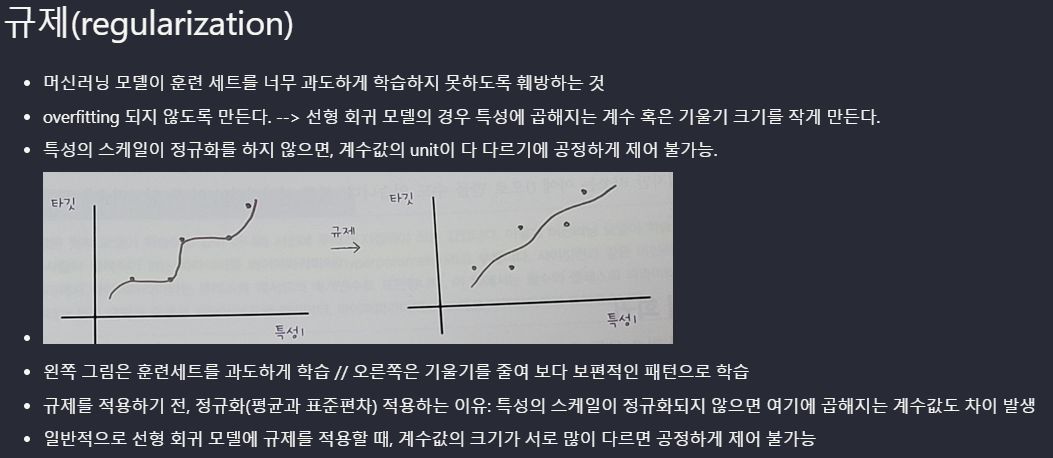

In [1212]:
from sklearn.linear_model import Ridge
ridge = Ridge()

scores = cross_validate(ridge, train_poly_scaled, train_target, return_train_score=True, n_jobs=-1) 
print() 
print(scores) 

print('Train R^2:', np.round(np.mean(scores['train_score']), 3)) 
print('Train_validation R^2:', np.round(np.mean(scores['test_score']), 3)) 


ridge.fit(train_poly_scaled, train_target) 
print('Test R^2:', np.round(ridge.score(test_poly_scaled, test_target), 3))


prediction = np.round(ridge.predict(test_poly_scaled), 2) 
mae = mean_absolute_error(test_target, prediction) 
print('|(타깃 - 예측값)|:', mae) 
Diff = np.round(prediction - test_target, 2) 


{'fit_time': array([2.52569127, 2.5630157 , 2.5806725 , 2.50869155, 2.5367136 ]), 'score_time': array([0.00404263, 0.0030098 , 0.00300932, 0.00400257, 0.00500011]), 'test_score': array([0.8121763 , 0.77508605, 0.78640511, 0.76439205, 0.77741231]), 'train_score': array([0.8326943 , 0.84183518, 0.835658  , 0.84270755, 0.83951902])}
Train R^2: 0.838
Train_validation R^2: 0.783
Test R^2: 0.792
|(타깃 - 예측값)|: 2.173515103202659


> #### 릿지와 라쏘 모델 특징
- 1) 릿지: 계수를 제곱한 값을 기준으로 규제를 적용
- 2) 라쏘: 계수의 절댓값을 기준으로 규제를 적용.
- 3) 릿지를 조금 더 선호 / 릿지 & 라쏘 모두 계수의 크기를 줄이지만 라쏘는 아예 0으로 만들 수 있다.
- 4) 2가지 모델, 모두 규제의 양을 임의로 조절
- 5) 모델 객체를 만들 때, alpha 매개변수로 규제의 강도 조절 가능
    - alpha값이 크면 규제 강도 세고 & 계수값 줄임 => 과소적합 유도
    - alpha값이 작으면 규제 강도 약해짐 & 계수값을 줄이는 역할 감소 => 과대적합될 가능성이 높다.   

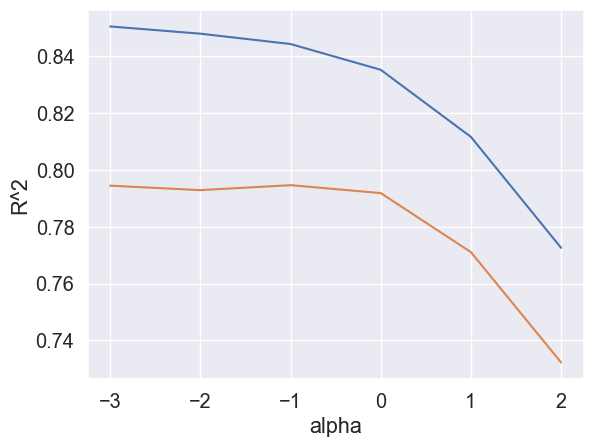

In [1213]:
alpha_list = [0.001, 0.01, 0.1, 1, 10, 100]

train_score = []
test_score = []

for alpha in alpha_list:
    ## 릿지 모델 생성
    ridge = Ridge(alpha=alpha)
    ridge.fit(train_poly_scaled, train_target)
    
    ## 훈련점수와 테스트 점수 저장
    train_score.append(ridge.score(train_poly_scaled, train_target))
    test_score.append(ridge.score(test_poly_scaled, test_target))
    
plt.plot(np.log10(alpha_list), train_score)
plt.plot(np.log10(alpha_list), test_score)
plt.xlabel('alpha')
plt.ylabel('R^2')
plt.show()

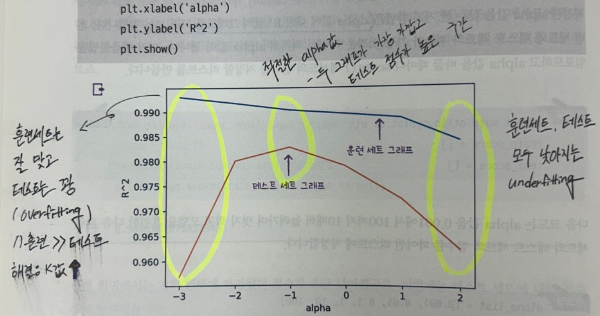

- alpha =1 로 변경하여 훈련 진행

In [1214]:
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=1)

scores = cross_validate(ridge, train_poly_scaled, train_target, return_train_score=True, n_jobs=-1) 
print() 
print(scores) 

print('Train R^2:', np.round(np.mean(scores['train_score']), 3)) 
print('Train_validation R^2:', np.round(np.mean(scores['test_score']), 3)) 


ridge.fit(train_poly_scaled, train_target) 
print('Test R^2:', np.round(ridge.score(test_poly_scaled, test_target), 3))


prediction = np.round(ridge.predict(test_poly_scaled), 2) 
mae = mean_absolute_error(test_target, prediction) 
print('|(타깃 - 예측값)|:', mae) 
Diff = np.round(prediction - test_target, 2) 


{'fit_time': array([2.44273925, 2.50380635, 2.47091675, 2.51587081, 2.47990131]), 'score_time': array([0.00599504, 0.00400257, 0.00501227, 0.00598836, 0.00501204]), 'test_score': array([0.8121763 , 0.77508605, 0.78640511, 0.76439205, 0.77741231]), 'train_score': array([0.8326943 , 0.84183518, 0.835658  , 0.84270755, 0.83951902])}
Train R^2: 0.838
Train_validation R^2: 0.783
Test R^2: 0.792
|(타깃 - 예측값)|: 2.173515103202659


>#### 라쏘 사용하기

In [1215]:
from sklearn.linear_model import Lasso
lasso = Lasso()

scores = cross_validate(lasso, train_poly_scaled, train_target, return_train_score=True, n_jobs=-1) 
print() 
print(scores) 

print('Train R^2:', np.round(np.mean(scores['train_score']), 3)) 
print('Train_validation R^2:', np.round(np.mean(scores['test_score']), 3)) 


lasso.fit(train_poly_scaled, train_target) 
print('Test R^2:', np.round(lasso.score(test_poly_scaled, test_target), 3))


prediction = np.round(lasso.predict(test_poly_scaled), 2) 
mae = mean_absolute_error(test_target, prediction) 
print('|(타깃 - 예측값)|:', mae) 
Diff = np.round(prediction - test_target, 2) 


{'fit_time': array([0.63493371, 0.53562069, 0.649894  , 0.63371134, 0.56291509]), 'score_time': array([0.00550508, 0.00635195, 0.00535512, 0.00621843, 0.00592375]), 'test_score': array([0.22707042, 0.22256132, 0.19606695, 0.20062202, 0.20917169]), 'train_score': array([0.20520666, 0.21160226, 0.21792966, 0.21435101, 0.22632933])}
Train R^2: 0.215
Train_validation R^2: 0.211
Test R^2: 0.228
|(타깃 - 예측값)|: 4.546466451877842


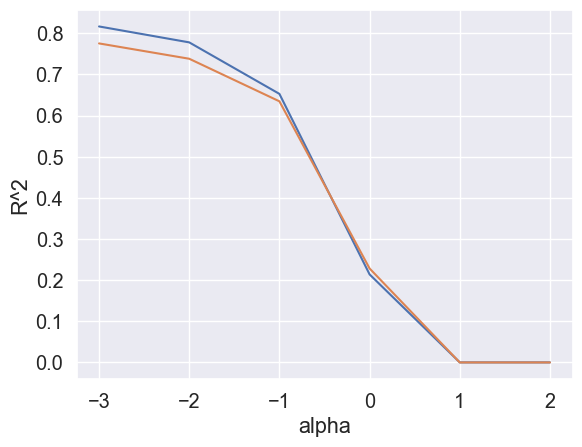

In [1216]:
alpha_list = [0.001, 0.01, 0.1, 1, 10, 100]

train_score = []
test_score = []

for alpha in alpha_list:
    ## 릿지 모델 생성
    lasso = Lasso(alpha=alpha)
    lasso.fit(train_poly_scaled, train_target)
    
    ## 훈련점수와 테스트 점수 저장
    train_score.append(lasso.score(train_poly_scaled, train_target))
    test_score.append(lasso.score(test_poly_scaled, test_target))
    
plt.plot(np.log10(alpha_list), train_score)
plt.plot(np.log10(alpha_list), test_score)
plt.xlabel('alpha')
plt.ylabel('R^2')
plt.show()

In [1217]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=0.1)

scores = cross_validate(lasso, train_poly_scaled, train_target, return_train_score=True, n_jobs=-1) 
print() 
print(scores) 

print('Train R^2:', np.round(np.mean(scores['train_score']), 3)) 
print('Train_validation R^2:', np.round(np.mean(scores['test_score']), 3)) 


lasso.fit(train_poly_scaled, train_target) 
print('Test R^2:', np.round(lasso.score(test_poly_scaled, test_target), 3))


prediction = np.round(lasso.predict(test_poly_scaled), 2) 
mae = mean_absolute_error(test_target, prediction) 
print('|(타깃 - 예측값)|:', mae) 
Diff = np.round(prediction - test_target, 2) 


{'fit_time': array([1.19672489, 2.69483232, 0.93916297, 0.97357106, 1.10497689]), 'score_time': array([0.00369596, 0.01207972, 0.00463796, 0.0050385 , 0.01035023]), 'test_score': array([0.67010186, 0.619655  , 0.61502729, 0.60802444, 0.61860919]), 'train_score': array([0.64785074, 0.65918143, 0.65753238, 0.66188193, 0.6549311 ])}
Train R^2: 0.656
Train_validation R^2: 0.626
Test R^2: 0.635
|(타깃 - 예측값)|: 2.9744076717436263


In [1218]:
## 라쏘 모델을 이용하여, 유용한 특성을 골라내는 용도로 사용
print(np.sum(lasso.coef_ == 0))
print(train_poly_scaled.shape)
print('유용한 feature 개수:', train_poly_scaled.shape[1] - np.sum(lasso.coef_ == 0))

2450
(4352, 2627)
유용한 feature 개수: 177


---
#### 4) 확률적 경사 하강법
- 확률적이란 말은 '무작위하게' 혹은 '랜덤하게'의 기술적인 표현
- 경사는 기울기를 의미하며, 가장 가파른 경사를 따라 원하는 지점에 도달
- 전체 샘플을 사용하지 않고 딱 하나의 샘플을 훈련 세트에서 랜덤하게 골라 가장 가파른 길을 찾는다.
- 모든 샘플을 다 사용하였을 경우에도 다 내려가지 못했다며(손실함수), 다시 처음부터 시작 --> 훈련세트를 한번 모두 사용하는 과정을 에포크

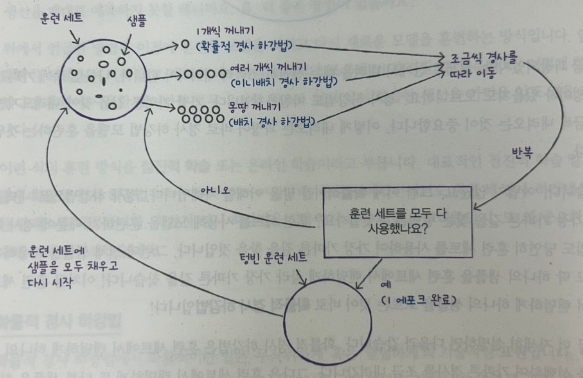

> #### 손실함수(내려가려고 하는 목표)?
- 어떤 문제에서 머신러닝 알고리즘이 얼마나 엉터리인지를 측정하는 기준
- 그렇기에 손실함수의 값이 작을수록 성능 우수
- 하지만 어떤 값이 최소값인지는 알지 못함.
- 가능한 많이 찾아보고 만족할만한 수준이라면, 인정해야 함.

In [1219]:
from sklearn.linear_model import SGDRegressor

sgdreg = SGDRegressor(max_iter=1000, tol=None, penalty=None, eta0=0.001)

scores = cross_validate(sgdreg, train_scaled, train_target, return_train_score=True, n_jobs=-1) 
print() 
print(scores) 

print('Train R^2:', np.round(np.mean(scores['train_score']), 3)) 
print('Train_validation R^2:', np.round(np.mean(scores['test_score']), 3)) 


sgdreg.fit(train_scaled, train_target) 
print('Test R^2:', np.round(sgdreg.score(test_scaled, test_target), 3))


prediction = np.round(sgdreg.predict(test_scaled), 2) 
mae = mean_absolute_error(test_target, prediction) 
print('|(타깃 - 예측값)|:', mae) 
Diff = np.round(prediction - test_target, 2) 


{'fit_time': array([0.72203374, 0.72804952, 0.73738241, 0.72804952, 0.73332906]), 'score_time': array([0.00099063, 0.00106263, 0.00106931, 0.00106263, 0.00098395]), 'test_score': array([0.56697573, 0.52283189, 0.5039948 , 0.48203335, 0.48863743]), 'train_score': array([0.51594859, 0.52695419, 0.53068164, 0.53679343, 0.53315909])}
Train R^2: 0.529
Train_validation R^2: 0.513
Test R^2: 0.504
|(타깃 - 예측값)|: 3.4594288036952445


- 에포크와 과대/과소적합: 에포크 횟수에 따라서 과소적합이나 과대적합이 발생

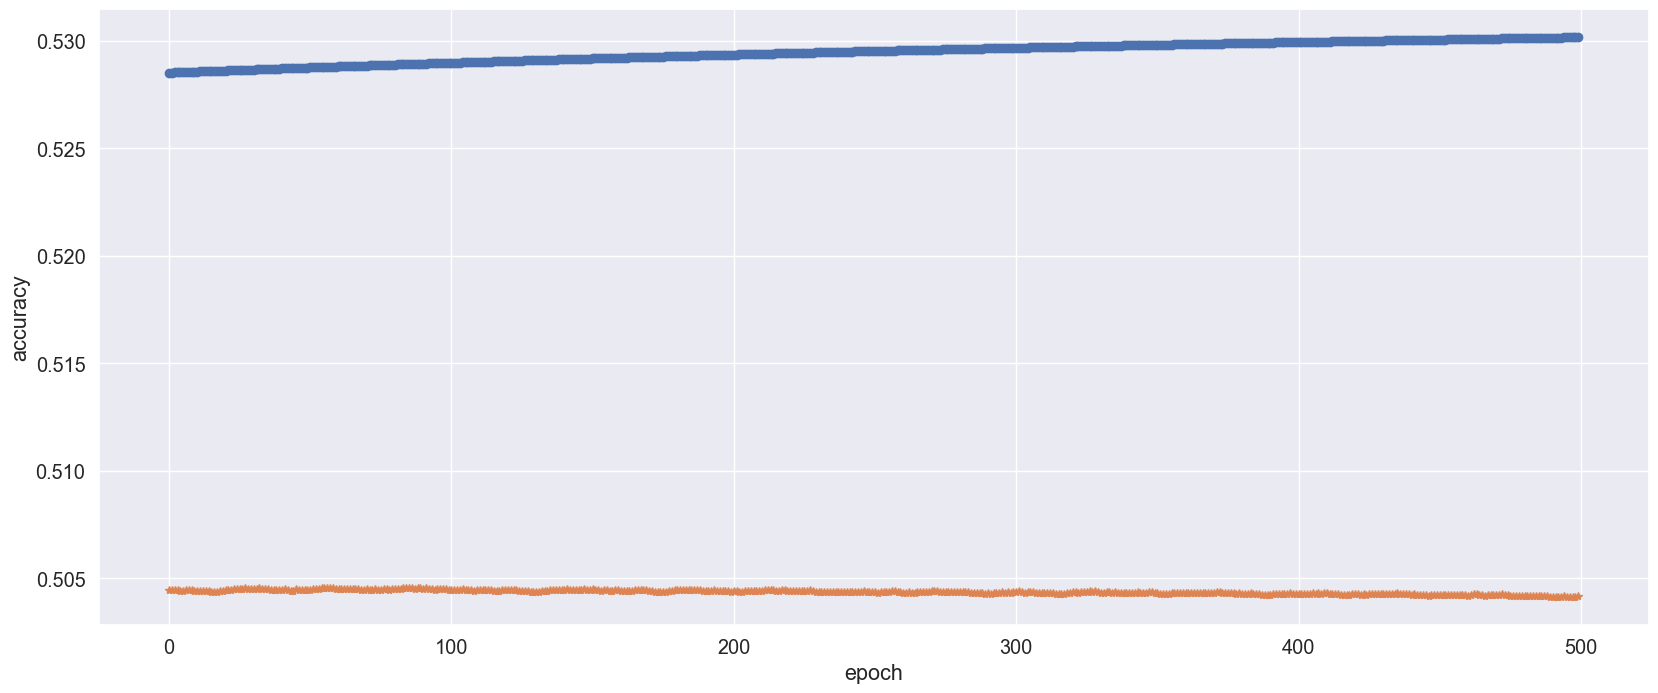

In [1220]:
train_score = [] 
test_score = []

for _ in range(0, 500):
    sgdreg.partial_fit(train_scaled, train_target)
    train_score.append(sgdreg.score(train_scaled, train_target))
    test_score.append(sgdreg.score(test_scaled, test_target))

plt.subplots(figsize=(20, 8))    
plt.plot(train_score, marker='o')
plt.plot(test_score, marker='*' )
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.show()

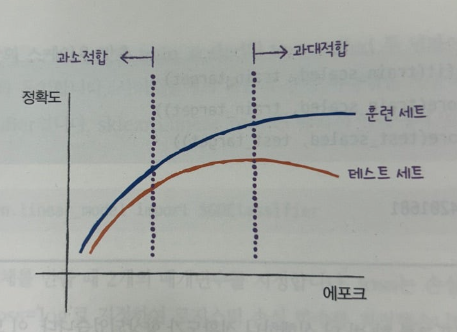

#### 5) 결정트리: 모델이 이유를 설명하기 쉽다.
- 스무고개와 같이 질문을 하니씩 던져서 정답을 맞워간다.
- 데이터를 잘 나눌 수 있다면, 계속 질문을 추가해서 분류 및 회귀의 정확도를 높일 수 있다.

In [1237]:
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor(max_depth=18)

scores = cross_validate(dt, train_scaled, train_target, return_train_score=True, n_jobs=-1) 
print() 
print(scores) 

print('Train R^2:', np.round(np.mean(scores['train_score']), 3)) 
print('Train_validation R^2:', np.round(np.mean(scores['test_score']), 3)) 


dt.fit(train_scaled, train_target) 
print('Test R^2:', np.round(dt.score(test_scaled, test_target), 3))


prediction = np.round(dt.predict(test_scaled), 2) 
mae = mean_absolute_error(test_target, prediction) 
print('|(타깃 - 예측값)|:', mae) 
Diff = np.round(prediction - test_target, 2) 


{'fit_time': array([0.04025555, 0.03925586, 0.03725743, 0.04025555, 0.04202151]), 'score_time': array([0.00107694, 0.00107694, 0.0009985 , 0.00227785, 0.00147295]), 'test_score': array([0.80572463, 0.68245367, 0.80008624, 0.80748351, 0.66634285]), 'train_score': array([0.97950988, 0.98927725, 0.99440203, 0.98722661, 0.98178735])}
Train R^2: 0.986
Train_validation R^2: 0.752
Test R^2: 0.81
|(타깃 - 예측값)|: 1.8307714096924055


> #### 결정트리 출력

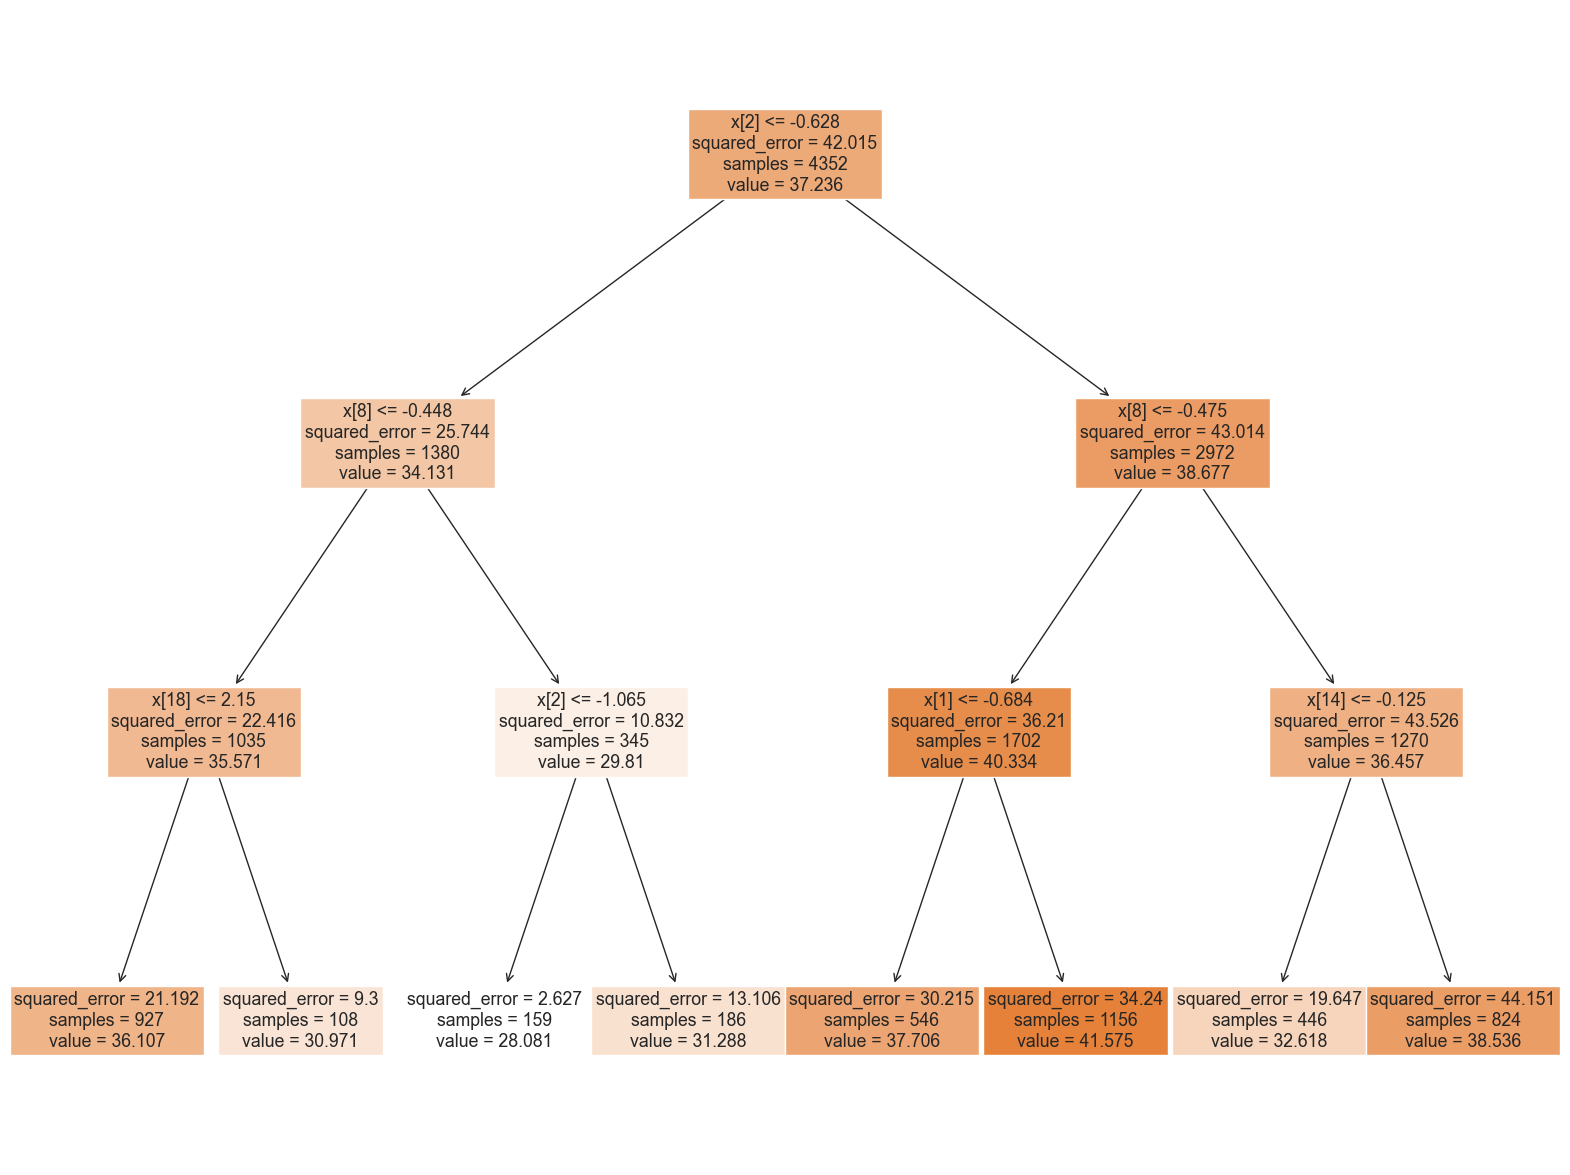

In [1242]:
from sklearn.tree import plot_tree

dt = DecisionTreeRegressor(max_depth=3)
dt.fit(train_scaled, train_target) 

plt.figure(figsize=(20,15))

plot_tree(dt, filled=True)
plt.show()

> #### 

#### 5) RandomForest-Regressor 모델 사용하기

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint


model_random = RandomForestRegressor(max_depth=40, max_features='sqrt', min_samples_split=2, n_estimators=90, n_jobs=-1)


scores = cross_validate(model_random, train_input, train_target, scoring='neg_root_mean_squared_error', 
                        cv=5,return_train_score=True, n_jobs=-1)
print()
print(scores)


train_rmse = (-1 * scores['train_score']).mean()
train_val_rmse = (-1 * scores['test_score']).mean()
print(f'Train RMSE: {train_rmse:.3f}')
print(f'train_val RMSE: {train_val_rmse:.3f}')


model_random.fit(train_input, train_target)
test_prediction = model_random.predict(test_input)
test_rmse = mean_squared_error(test_target, test_prediction)
print(f'Test RMSE: {test_rmse:.3f}')


mae = mean_absolute_error(test_target, test_prediction)
print(f'|(타깃 - 예측값)|: {mae:.3f}')

#### 4) R2 확인 및 데이터 추출(RandomForest)

In [ ]:
scores = cross_validate(model_random, train_input, train_target, return_train_score=True, n_jobs=-1) 
print() 
print(scores) 

print('Train R^2:', np.round(np.mean(scores['train_score']), 3)) 
print('Train_validation R^2:', np.round(np.mean(scores['test_score']), 3)) 


model_random.fit(train_input, train_target) 
print('Test R^2:', np.round(model_random.score(test_input, test_target), 3))


prediction = np.round(model_random.predict(test_input), 2) 
mae = mean_absolute_error(test_target, prediction) 
print('|(타깃 - 예측값)|:', mae) 
Diff = np.round(prediction - test_target, 2) 


# inverseTest = ss.inverse_transform(test_input)


pdTestData = pd.DataFrame(test_input, columns=nameColumns)
pdTestTarget = pd.DataFrame(test_target,  columns=['TemperatureC'])
pdPredData = pd.DataFrame(prediction, columns=['prediction'])


test_result = pd.concat([pdTestData, pdTestTarget, pdPredData], axis=1)
test_result.to_csv("model_random_test_result.csv")

---
>### 하이퍼파라미터 최적화 & 파라미터 찾기

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import uniform, randint


# hyperparameter 세팅 시, 진행.
n_estimators = randint(20, 100)                 ## number of trees in the random forest
max_features = ['auto', 'sqrt']                 ## number of features in consideration at every split
max_depth = [int(x) for x in
             np.linspace(10, 120, num=12)]      ## maximum number of levels allowed in each decision tree
min_samples_split = [2, 6, 10]                  ## minimum sample number to split a node
min_samples_leaf = [1, 3, 4]                    ## minimum sample number that can be stored in a leaf node
bootstrap = [True, False]                       ## method used to sample data points

param_dist = {'n_estimators': n_estimators,
              'max_features': max_features,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'bootstrap': bootstrap}

# RandomizedSearchCV 객체 생성
model_random = RandomForestRegressor()
random_search = RandomizedSearchCV(model_random, param_distributions=param_dist, n_iter=100, 
                                   cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)


# 하이퍼파라미터 최적화
random_search.fit(train_input, train_target)

# 최적 하이퍼파라미터 출력
print('최적 하이퍼파라미터:', random_search.best_params_)

# 최적 모델 객체 생성
model_best = random_search.best_estimator_

In [ ]:
scores = cross_validate(model_best, train_input, train_target, scoring='neg_root_mean_squared_error', 
                        cv=5,return_train_score=True, n_jobs=-1)
print()
print(scores)


train_rmse = (-1 * scores['train_score']).mean()
train_val_rmse = (-1 * scores['test_score']).mean()
print(f'Train RMSE: {train_rmse:.3f}')
print(f'train_val RMSE: {train_val_rmse:.3f}')


model_best.fit(train_input, train_target)
test_prediction = model_best.predict(test_input)
test_rmse = mean_squared_error(test_target, test_prediction)
print(f'Test RMSE: {test_rmse:.3f}')


mae = mean_absolute_error(test_target, test_prediction)
print(f'|(타깃 - 예측값)|: {mae:.3f}')

---
>### log transform된 데이터 이용하기

In [ ]:
sns.distplot(log_temp , fit=norm)

## Get the fitted parameters used by the function
(mu, sigma) = norm.fit(log_temp)

## Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best', fontsize=10)
plt.ylabel('log_Temperature')
plt.title('log_Temperature distribution')

## TemperatureRise mean and median value display
plt.axvline(log_temp.mean(), color='black')
plt.axvline(log_temp.median(), color='blue')

## Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(log_temp, plot=plt)
plt.show()

#skewness and kurtosis
print("Skewness & Temp: %f" % log_temp.skew())
print("Kurtosis & Temp: %f" % log_temp.kurt())

#### log_temp 데이터프레임에 추가하고, feature list 선택하기

In [ ]:
AOP_data.head()

In [ ]:
data = AOP_data.iloc[:, 0:71].to_numpy()
target = AOP_data['log_temp'].to_numpy()

In [ ]:
train_input, test_input, train_target, test_target = train_test_split(data, target, test_size=0.2, shuffle=True)

#### 하이퍼파라미터 찾기

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import uniform, randint


# hyperparameter 세팅 시, 진행.
n_estimators = randint(20, 100)                 ## number of trees in the random forest
max_features = ['auto', 'sqrt']                 ## number of features in consideration at every split
max_depth = [int(x) for x in
             np.linspace(10, 120, num=12)]      ## maximum number of levels allowed in each decision tree
min_samples_split = [2, 6, 10]                  ## minimum sample number to split a node
min_samples_leaf = [1, 3, 4]                  ## minimum sample number that can be stored in a leaf node
bootstrap = [True, False]                     ## method used to sample data points

param_dist = {'n_estimators': n_estimators,
              'max_features': max_features,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'bootstrap': bootstrap}

# RandomizedSearchCV 객체 생성
model_random = RandomForestRegressor()
random_search = RandomizedSearchCV(model_random, param_distributions=param_dist, n_iter=100, 
                                   cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)


# 하이퍼파라미터 최적화
random_search.fit(train_input, train_target)

# 최적 하이퍼파라미터 출력
print('최적 하이퍼파라미터:', random_search.best_params_)

# 최적 모델 객체 생성
model_best = random_search.best_estimator_

In [ ]:
scores = cross_validate(model_best, train_input, train_target, scoring='neg_root_mean_squared_error', 
                        cv=5,return_train_score=True, n_jobs=-1)
print()
print(scores)


train_rmse = (-1 * scores['train_score']).mean()
train_val_rmse = (-1 * scores['test_score']).mean()
print(f'Train RMSE: {train_rmse:.3f}')
print(f'train_val RMSE: {train_val_rmse:.3f}')


model_best.fit(train_input, train_target)
test_prediction = model_best.predict(test_input)
test_rmse = mean_squared_error(test_target, test_prediction)
print(f'Test RMSE: {test_rmse:.3f}')


mae = mean_absolute_error(np.expm1(test_target), np.expm1(test_prediction))
print(f'|(타깃 - 예측값)|: {mae:.3f}')

---
### XGboost 모델 이용하기 with 하이퍼 파라미터

In [ ]:
import xgboost as xgb
from scipy.stats import uniform, randint


# 하이퍼파라미터 공간 정의
max_depth = [int(x) for x in np.linspace(3, 10, num=8)]  # 적절한 범위로 수정
n_estimators = randint(100, 1000)  # 트리 개수 범위 수정
learning_rate = uniform(0.01, 0.3)  # 학습률 범위
gamma = uniform(0, 0.5)
min_child_weight = [1, 3, 5]
max_delta_step = [1, 3, 5, 7, 9]
subsample = uniform(0.5, 1)
colsample_bytree = uniform(0.5, 1)  
reg_alpha = [0, 0.1, 1, 10]  # L1 정규화 계수
reg_lambda = [0, 0.1, 1, 10]  # L2 정규화 계수


param_dist = {
    'max_depth': max_depth,
    'n_estimators': n_estimators,
    'learning_rate': learning_rate,
    'gamma': gamma,
    'min_child_weight': min_child_weight,
    'max_delta_step': max_delta_step,
    'subsample': subsample,
    'colsample_bytree': colsample_bytree,
    'reg_alpha': reg_alpha,
    'reg_lambda': reg_lambda
}


# XGBRegressor 객체 생성
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)


# RandomizedSearchCV 객체 생성
random_search = RandomizedSearchCV(xgb_model, param_distributions=param_dist,
                                   n_iter=100, cv=5, scoring='neg_mean_squared_error',
                                   n_jobs=-1, verbose=2)


# 하이퍼파라미터 최적화
random_search.fit(train_input, train_target)


# 최적 하이퍼파라미터 출력
print('최적 하이퍼파라미터:', random_search.best_params_)


# 최적 모델 객체 생성
model_best = random_search.best_estimator_

In [ ]:
scores = cross_validate(model_best, train_input, train_target, scoring='neg_root_mean_squared_error', 
                        cv=5,return_train_score=True, n_jobs=-1)
print()
print(scores)


train_rmse = (-1 * scores['train_score']).mean()
train_val_rmse = (-1 * scores['test_score']).mean()
print(f'Train RMSE: {train_rmse:.3f}')
print(f'train_val RMSE: {train_val_rmse:.3f}')


model_best.fit(train_input, train_target)
test_prediction = model_best.predict(test_input)
test_rmse = mean_squared_error(test_target, test_prediction)
print(f'Test RMSE: {test_rmse:.3f}')


mae = mean_absolute_error(np.expm1(test_target), np.expm1(test_prediction))
print(f'|(타깃 - 예측값)|: {mae:.3f}')